# Thesis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from grid_cells import GridCells
from environment import GridCellWorld
from utils import get_coords, to_tensor, eval_locomotion, eval_position
from agent import Agent
from tqdm import tqdm

In [3]:
resolution = 400
MIN, MAX = -1, 1
N = 25
scales = np.linspace(150, 300, 30, dtype=int)

exploration_std = 0.05
bs=256
actor_hidden=128
critic_hidden=256
lr_a=1e-4
lr_c=3e-4
grad_norm=0.2
buffer_length=1000

n_episodes = 5000
episode_max_len = 30
stds = np.logspace(0, -3, n_episodes)

In [4]:
print("Agent params:")
print(f"Exploration std: np.logspace(0, -3, {n_episodes})")#, exploration_std)
print("Batch size:", bs)
print("Hidden size (actor):", actor_hidden)
print("Exploration std:", critic_hidden)
print("Learning rates (actor, critic):", lr_a, lr_c)
print("Gradient norm:", grad_norm)
print("Buffer length:", buffer_length)
print("Number of grid cells", 30 * N)
print("Episode length:", episode_max_len)

Agent params:
Exploration std: np.logspace(0, -3, 5000)
Batch size: 256
Hidden size (actor): 128
Exploration std: 256
Learning rates (actor, critic): 0.0001 0.0003
Gradient norm: 0.2
Buffer length: 1000
Number of grid cells 750
Episode length: 30


In [5]:
coords = get_coords(resolution, MIN, MAX)
gcs = GridCells(scales, n_per_module=N, res=resolution)
gcs.reset_modules(1)
gcs.compile_numpy()
grid_cells = gcs.grid_cells.transpose(1, 2, 0)
c, gc = to_tensor(coords), to_tensor(grid_cells)

In [12]:
env = GridCellWorld(gc, c, debug=False)
agent = Agent(grid_cells.shape[-1], 2, action_amp=0.1,
              bs=bs,
              actor_hidden=actor_hidden,
              critic_hidden=critic_hidden,
              lr_a=lr_a,
              lr_c=lr_c,
              grad_norm=grad_norm,
              buffer_length=buffer_length)
# state_trans = torch.randn(2, 3000, device=device)

In [13]:
try:
    rewards = list()
    lengths = list()
    for ep in tqdm(range(n_episodes)):
        done = False
        step = 0
        reward = list()
        agent.exploration_std = stds[ep]
        s, loc = env.reset(), env.state
        # s = s @ state_trans
        while not done and step < episode_max_len:
            a = agent.choose_action(s)
            s_new, r, done = env.next_state(a)
            # s_new = s_new @ state_trans
            agent.remember(s, a, r, s_new, done, loc)
            agent.learn()
            s, loc = s_new, env.state
            step += 1
            reward.append(r)
        lengths.append(step)
        rewards.append(sum(reward).cpu())
except KeyboardInterrupt:
    pass

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:11<00:00,  6.83it/s]


In [14]:
print("Agent reward - %.03f\nlengths - %.03f" % eval_locomotion(agent, env))
print(f"Position loss - {eval_position(agent):.03f}")

Starting evaluation


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 112.52it/s]


Agent reward - -1.409
lengths - 5.255
Position loss - 173.028


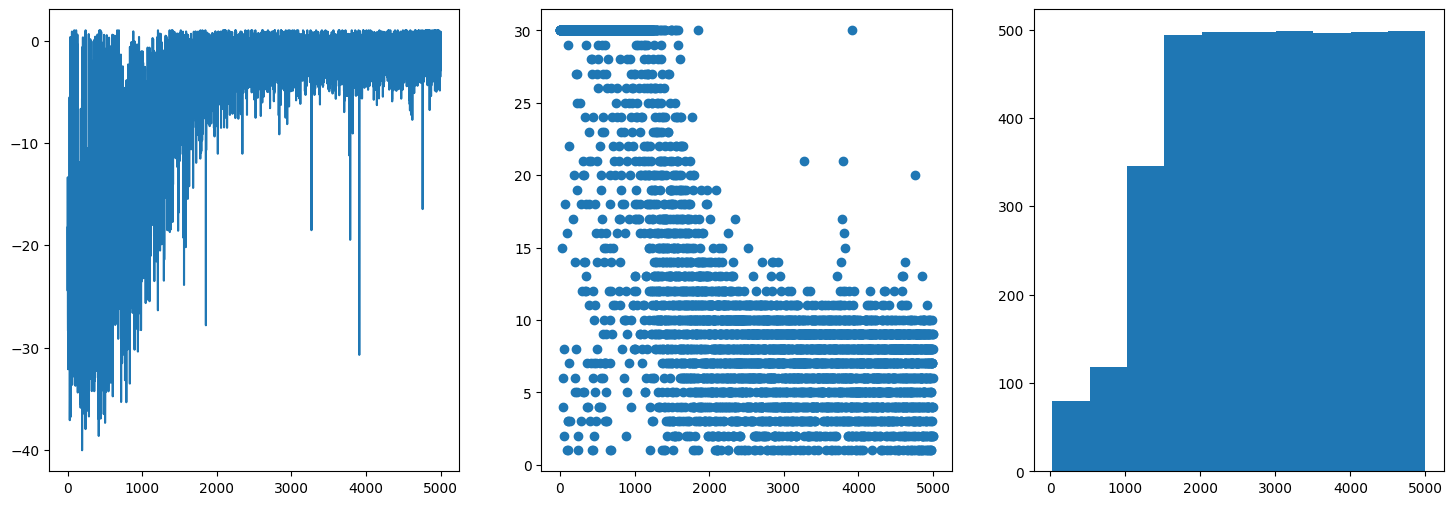

In [15]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.plot(to_tensor(rewards).cpu())
ax2.scatter(np.arange(len(lengths)), lengths)
ax3.hist(np.arange(len(lengths))[np.asarray(lengths) < episode_max_len])
plt.show()

In [20]:
idx = agent.actor.lin2.weight[:2].detach().cpu().abs().argsort(dim=-1)[:,-5:].numpy() + [[0], [actor_hidden]]
print(agent.actor.lin2.weight[:2].detach().cpu().flatten()[idx.flatten()])

tensor([-1.3479,  1.3656,  1.3866,  1.3918,  1.4110,  1.2086,  1.2601,  1.2601,
         1.2843,  1.4920])


In [53]:
import torch.nn as nn

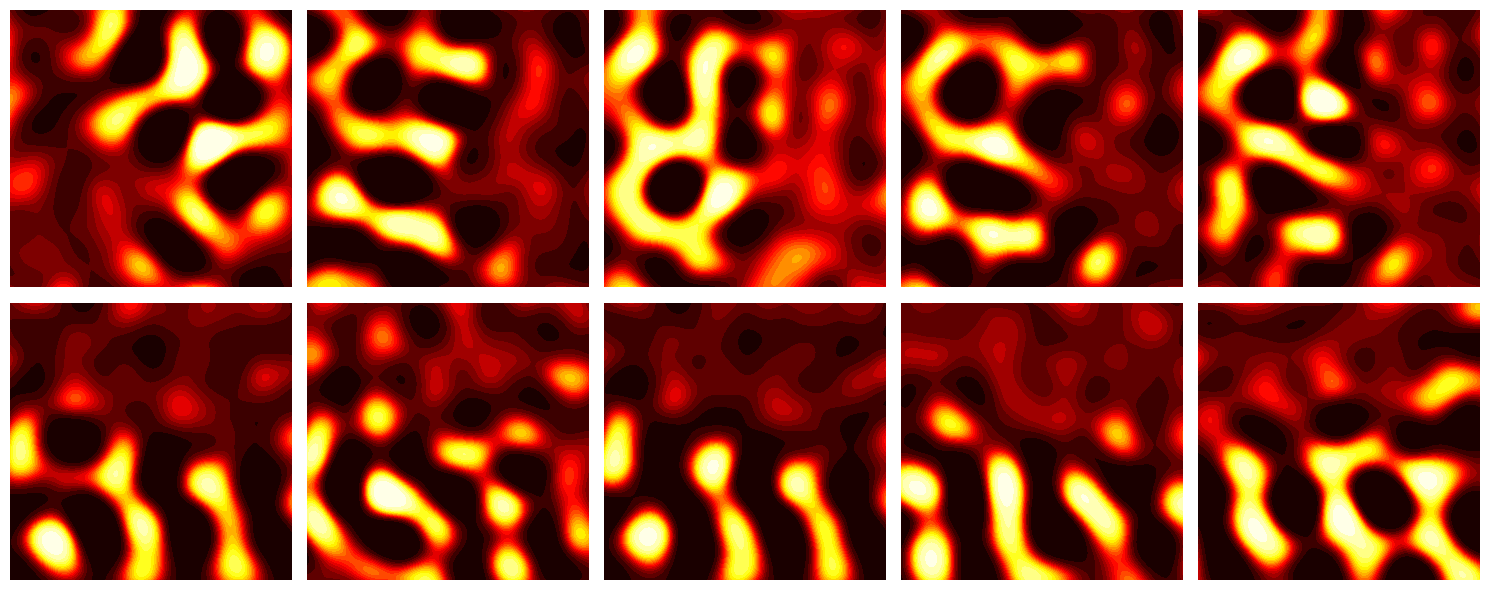

In [58]:
_, axs = plt.subplots(2, 5, figsize=(15, 6))

hidden = nn.functional.sigmoid(gc @ agent.actor.lin1.weight.T + agent.actor.lin1.bias).detach().cpu().numpy().transpose((-1, 0, 1))
idx = agent.actor.lin2.weight[:2].detach().cpu().abs().argsort(dim=-1)[:,-5:]
for img, ax in zip(hidden[idx.flatten()], axs.flatten()):
    ax.contourf(img, levels=20, cmap='hot')
    ax.axis('off')
plt.tight_layout()
plt.show()

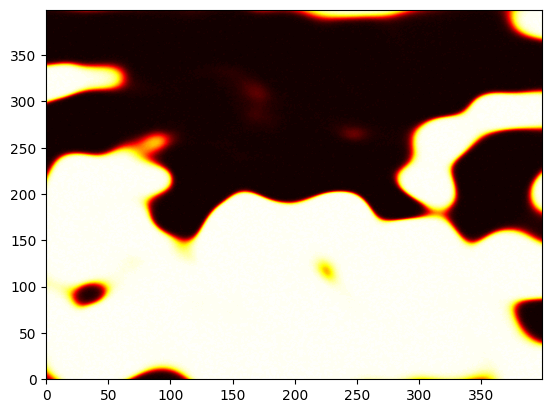

In [49]:
plt.contourf(agent.choose_action(gc.view(-1, 750)).view(resolution, resolution, -1)[:,:,1].cpu(), cmap='hot', levels=100)

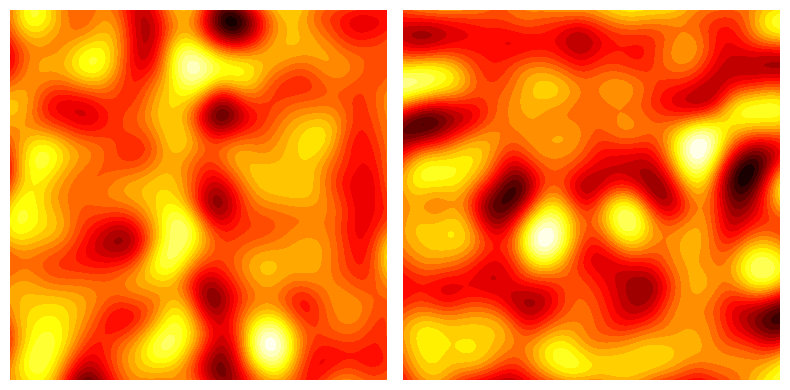

In [37]:
_, axs = plt.subplots(1, 2, figsize=(8, 4))

out = (to_tensor(hidden).permute(1, 2, 0) @ agent.actor.lin2.weight.T).detach().cpu().numpy().transpose((-1, 0, 1))
for img, ax in zip(out, axs.flatten()):
    ax.contourf(img, levels=20, cmap='hot')
    ax.axis('off')
plt.tight_layout()
plt.show()

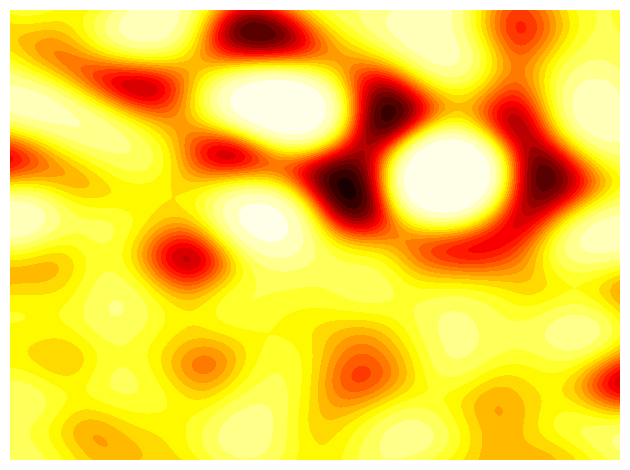

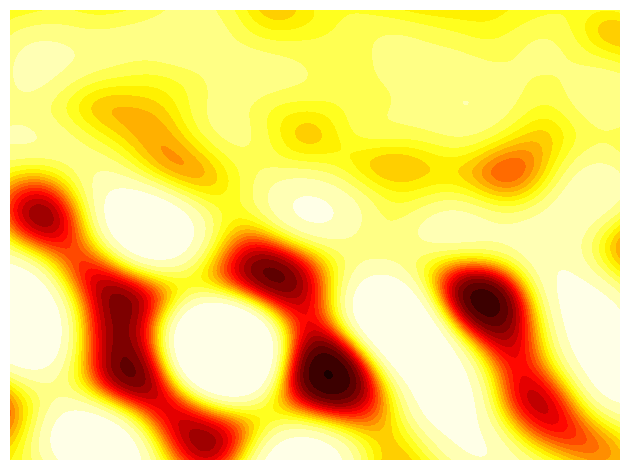

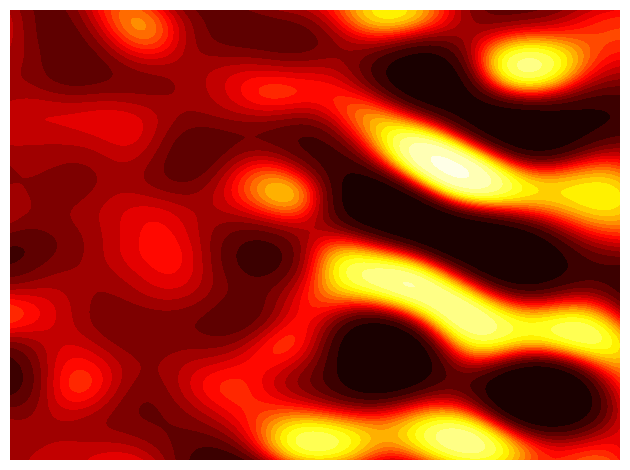

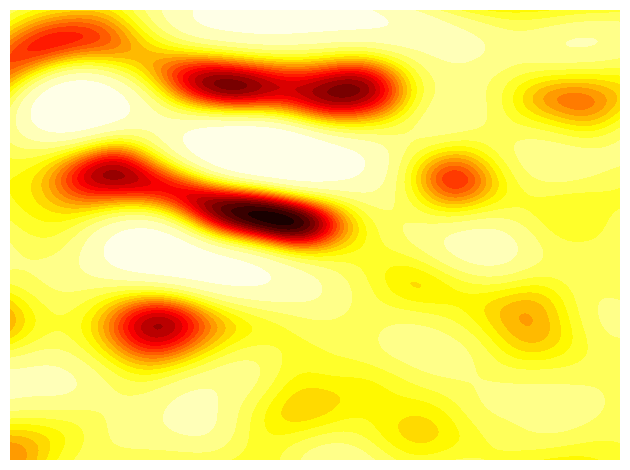

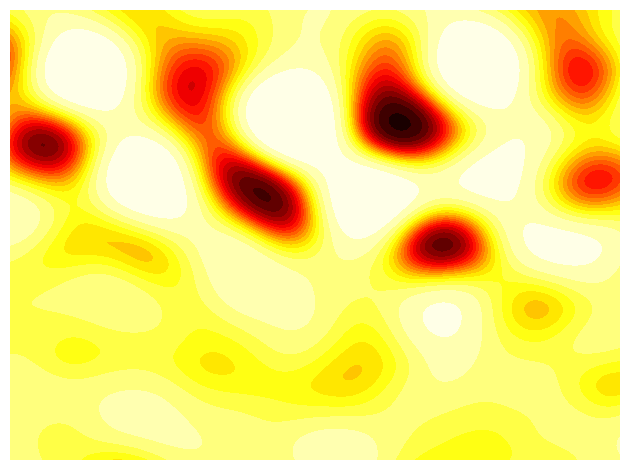

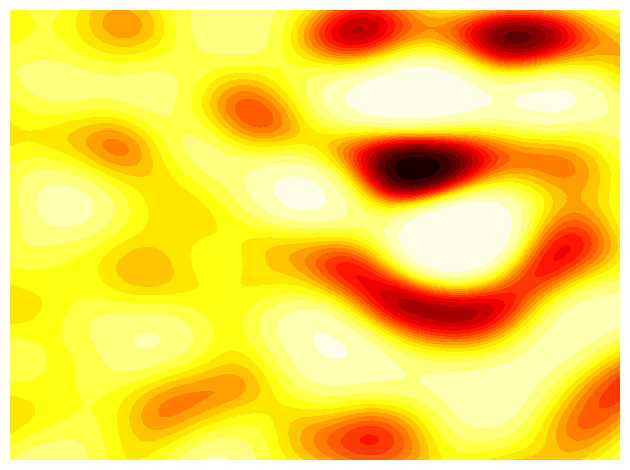

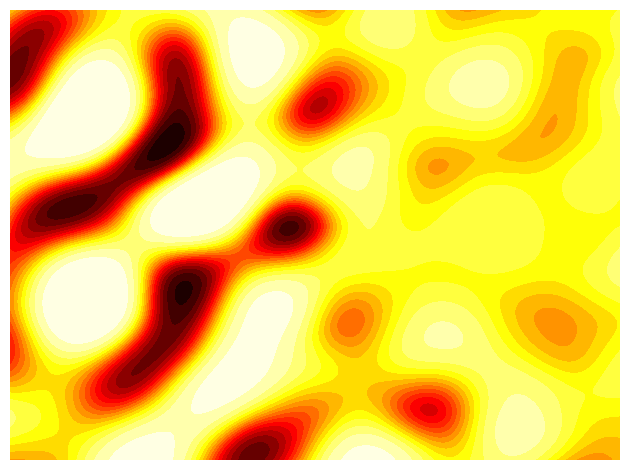

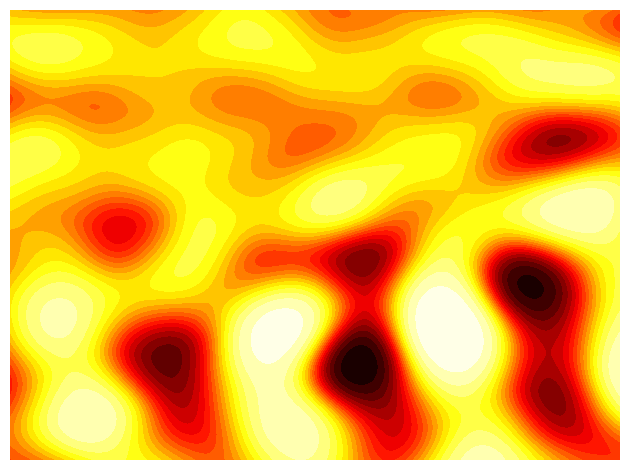

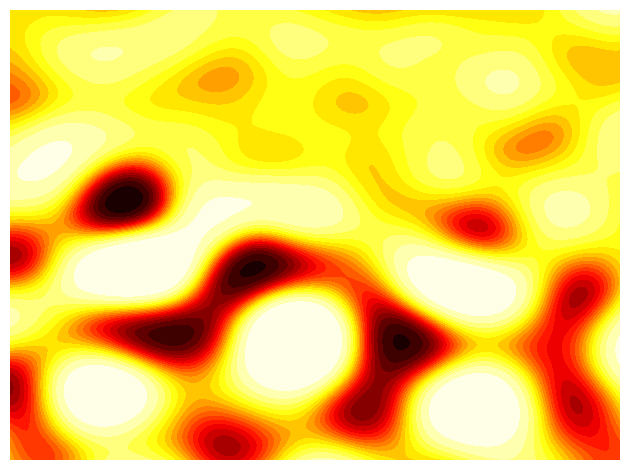

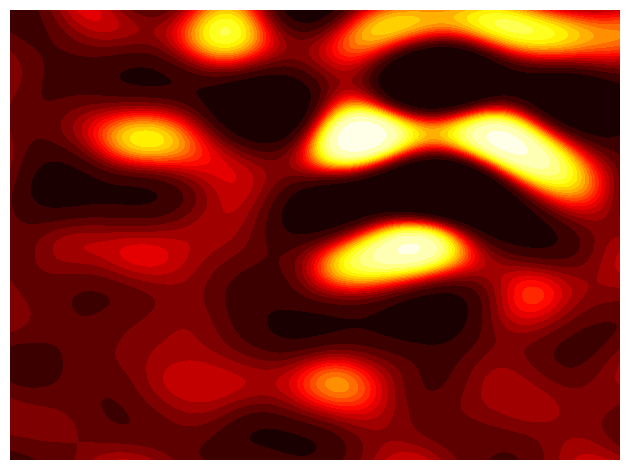

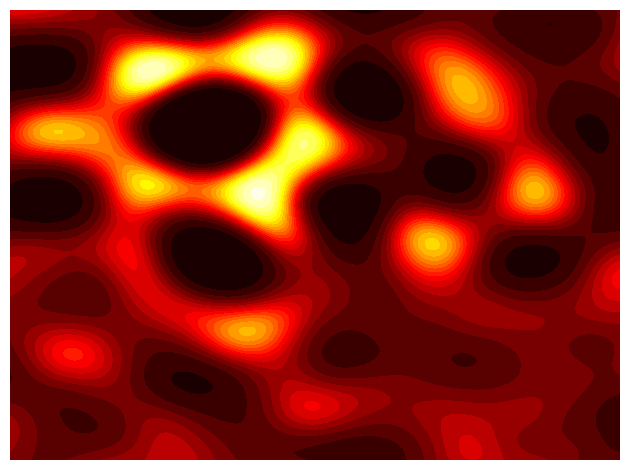

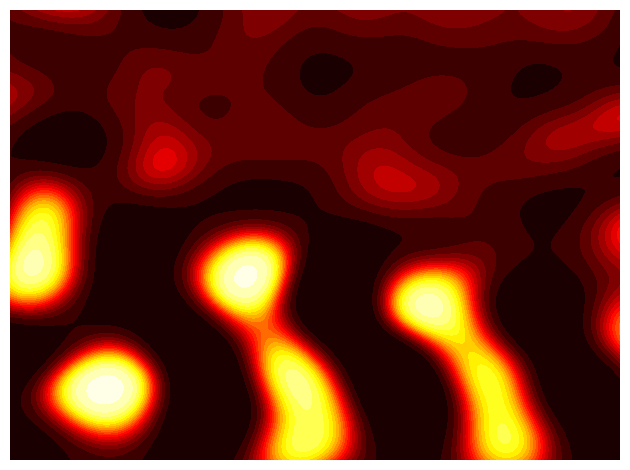

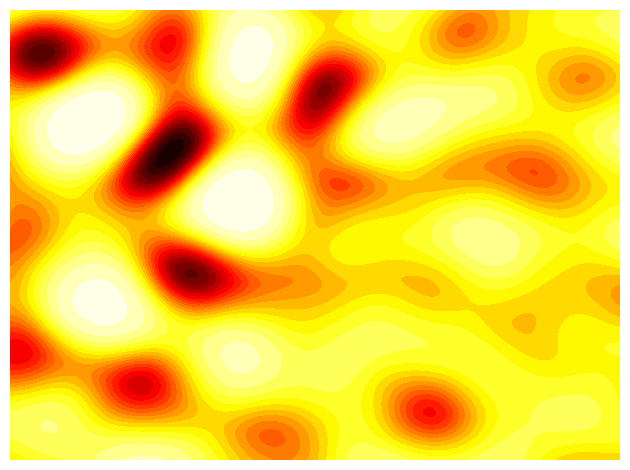

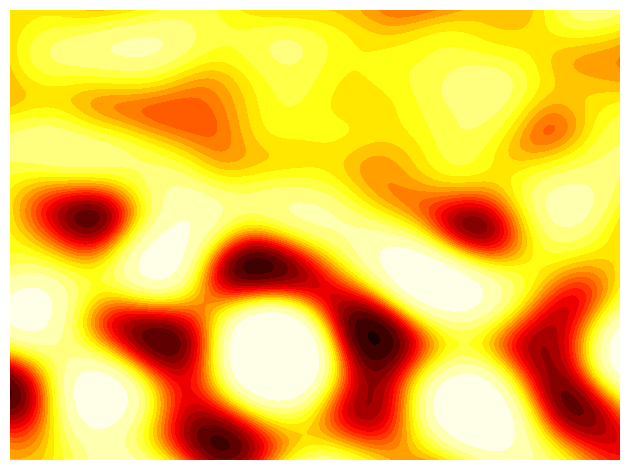

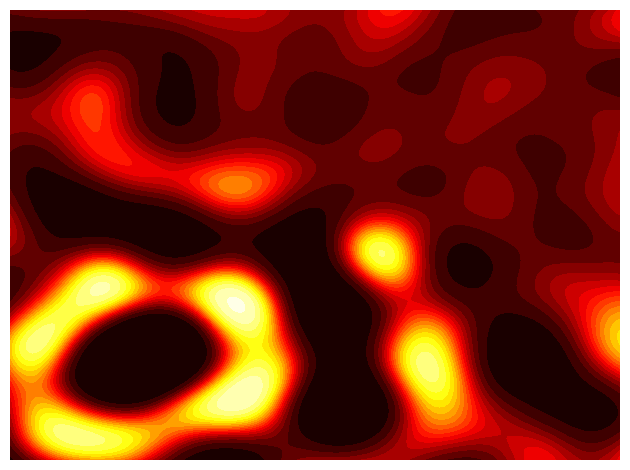

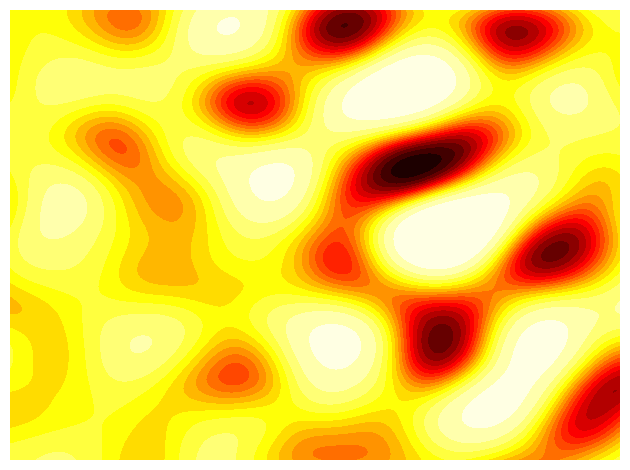

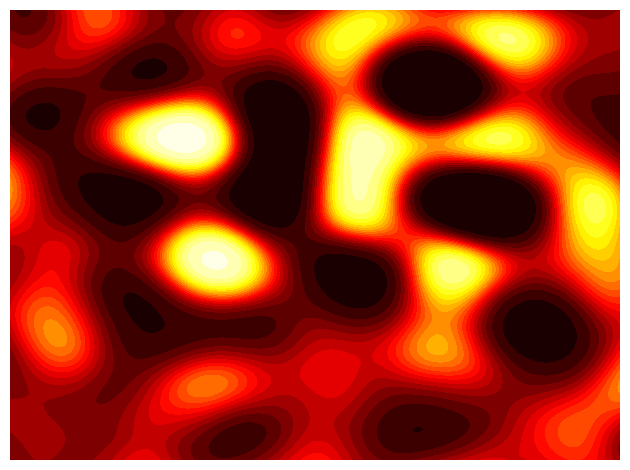

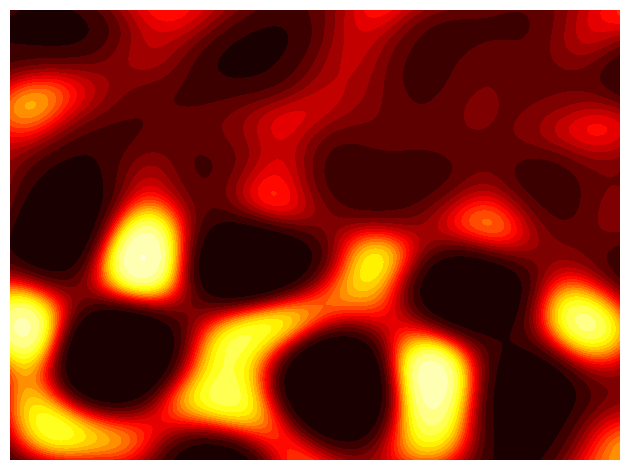

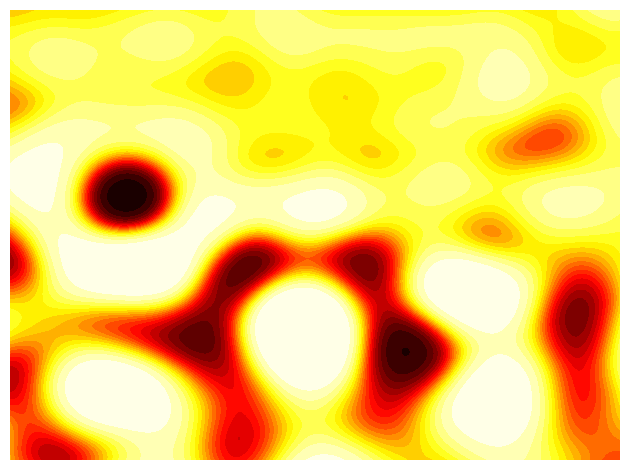

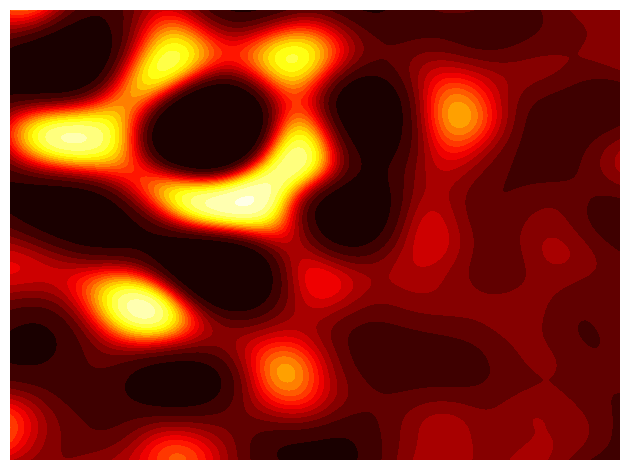

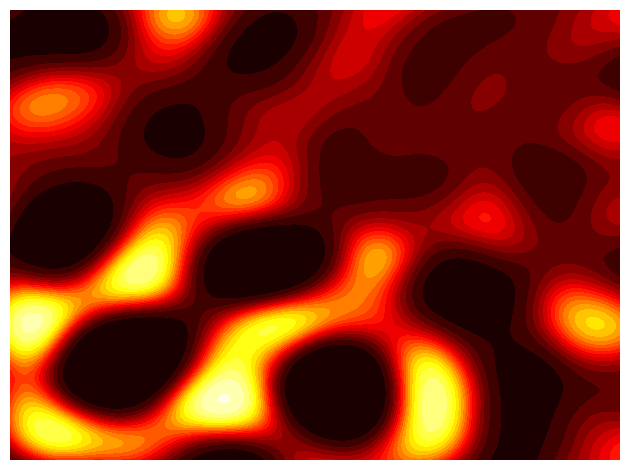

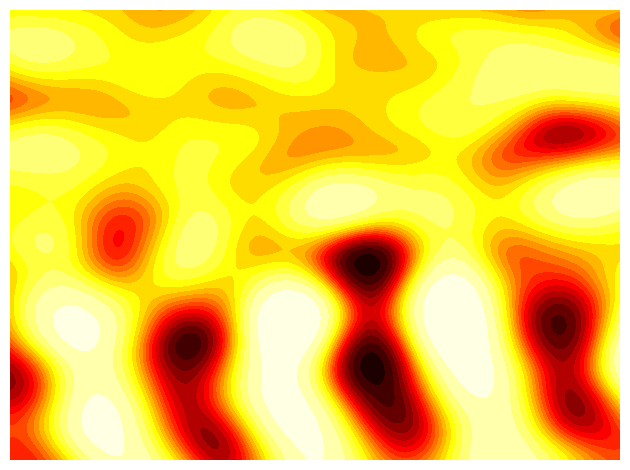

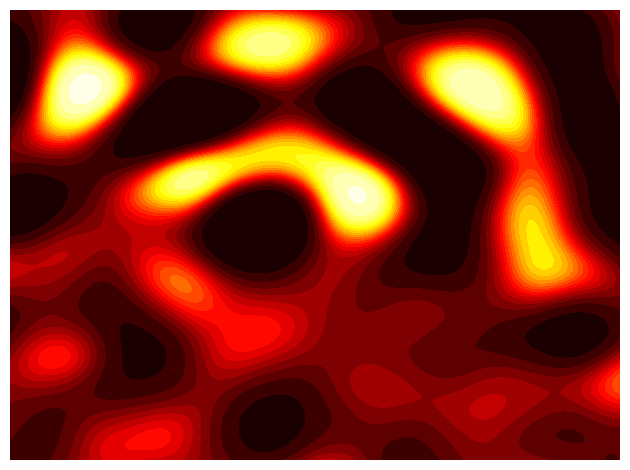

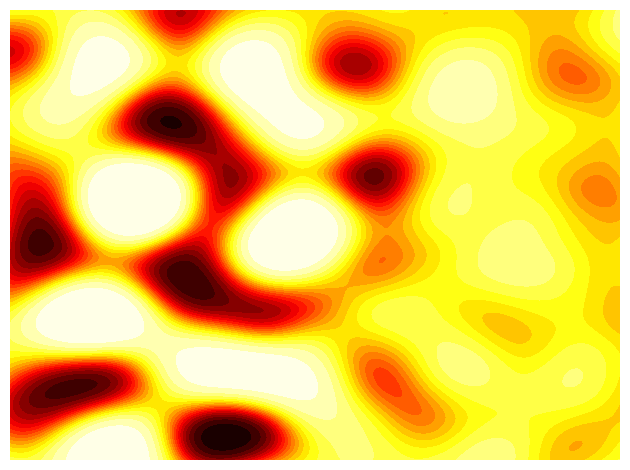

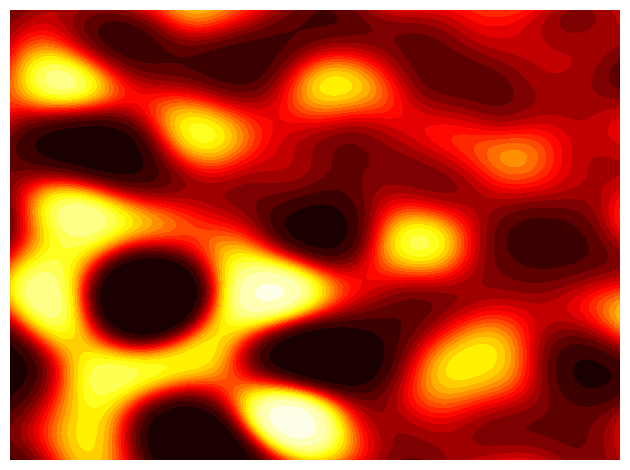

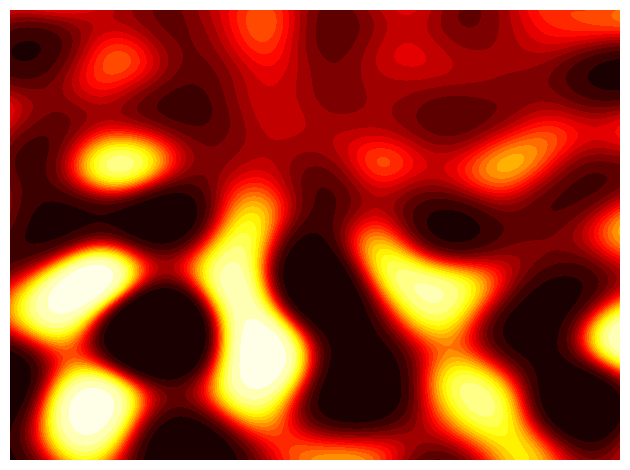

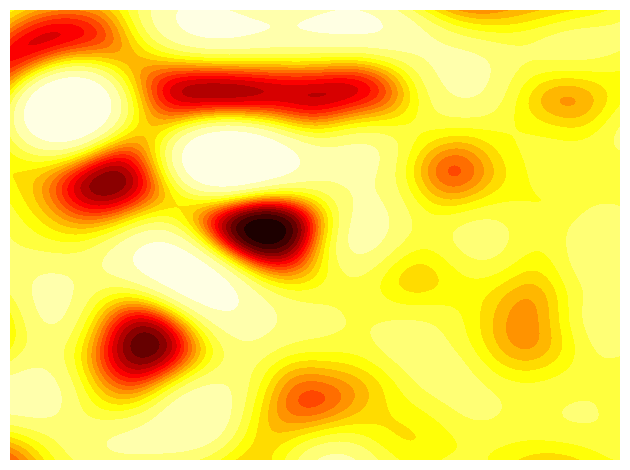

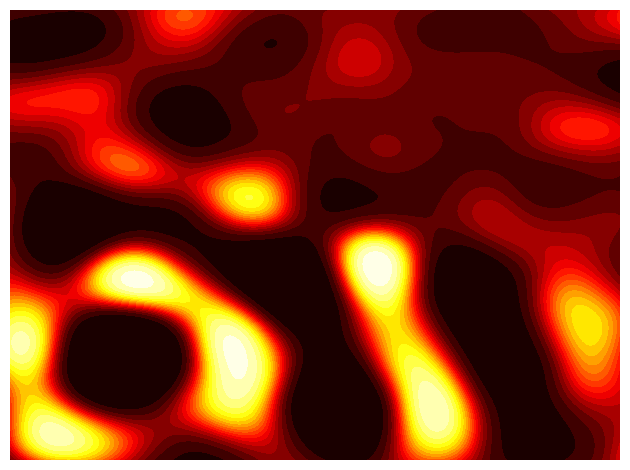

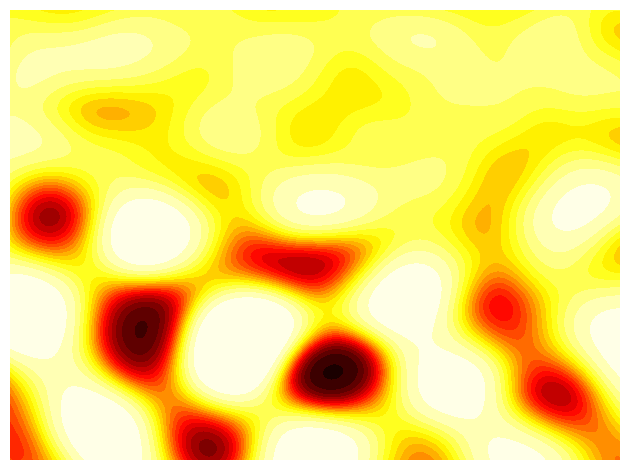

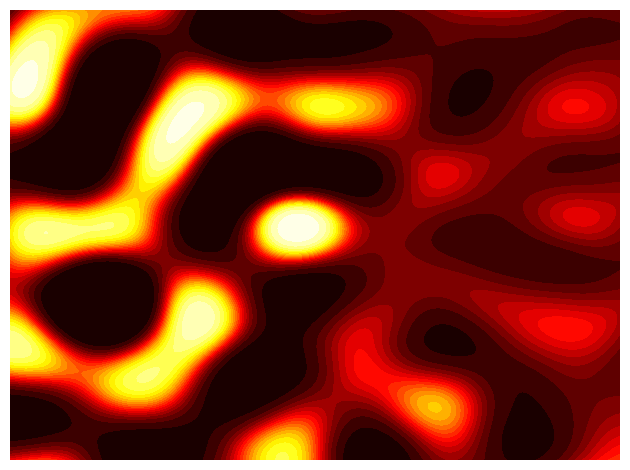

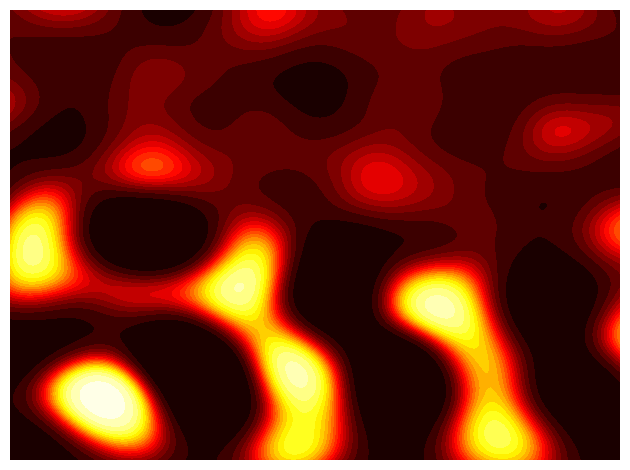

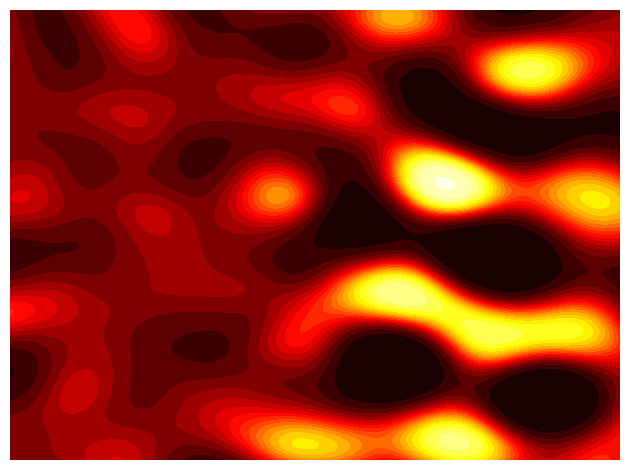

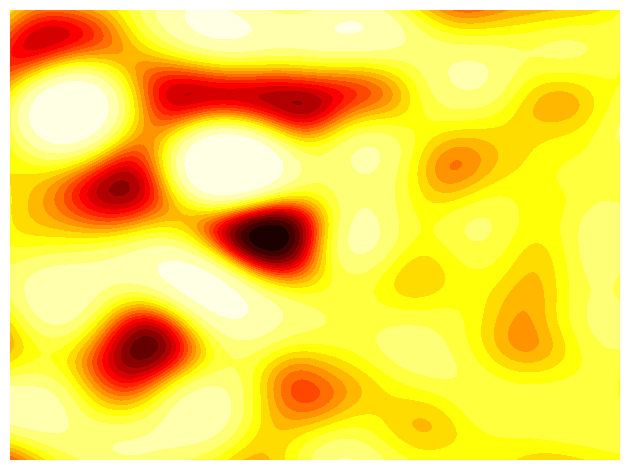

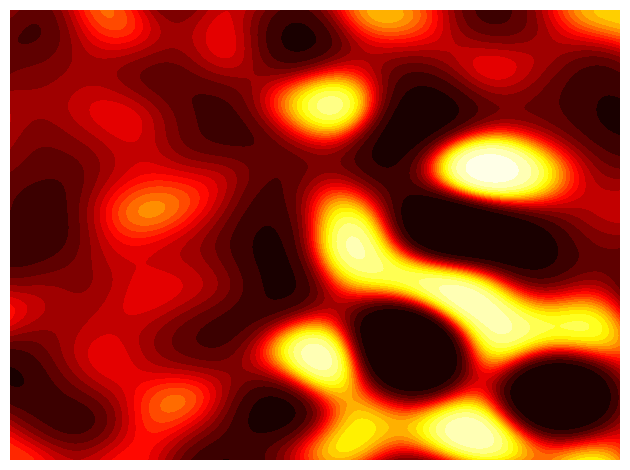

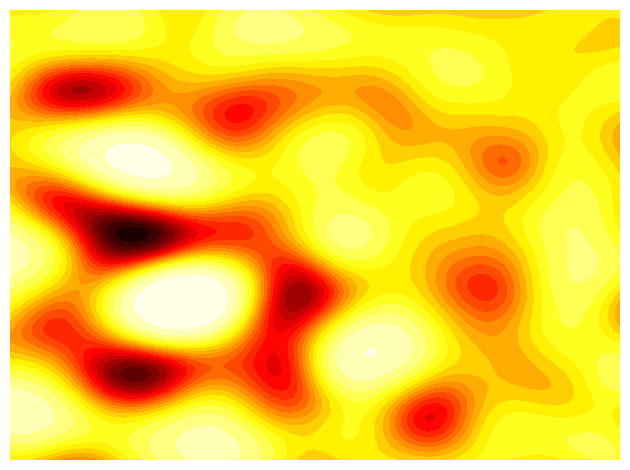

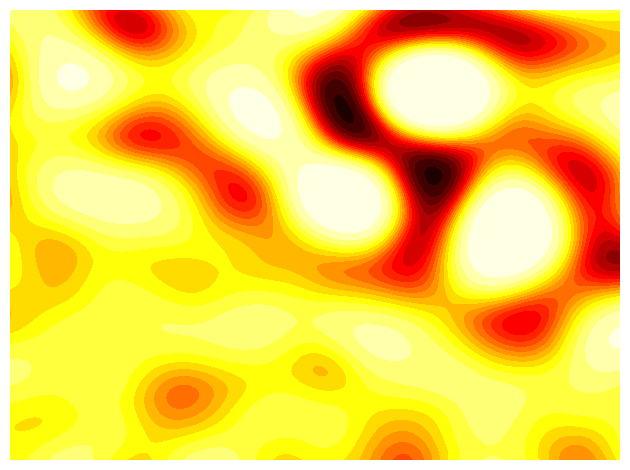

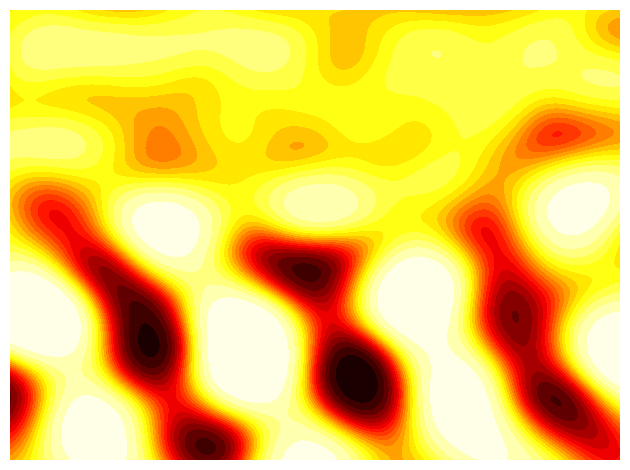

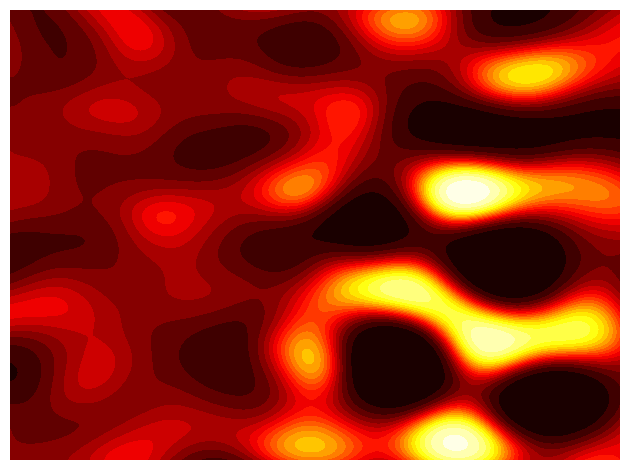

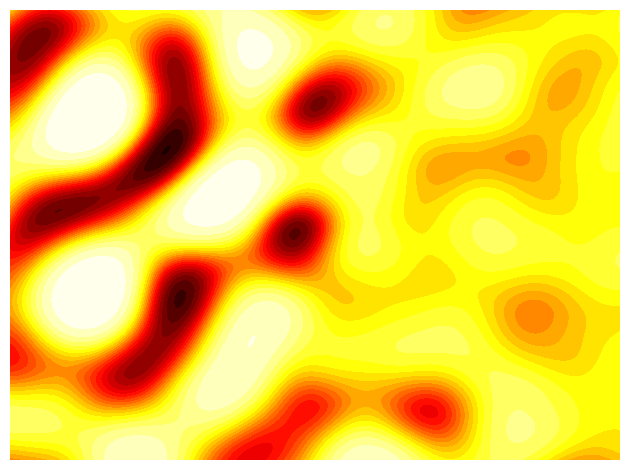

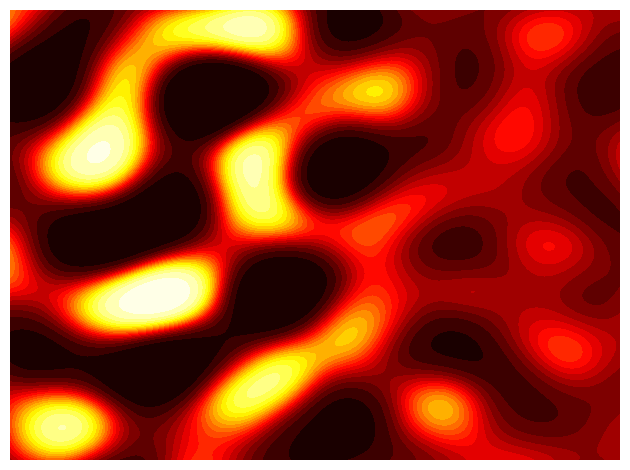

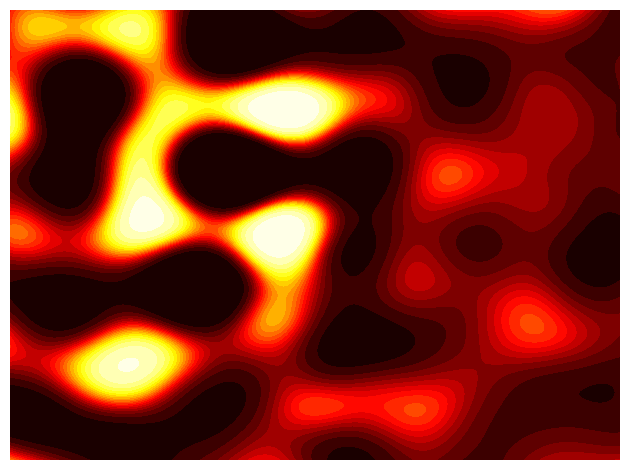

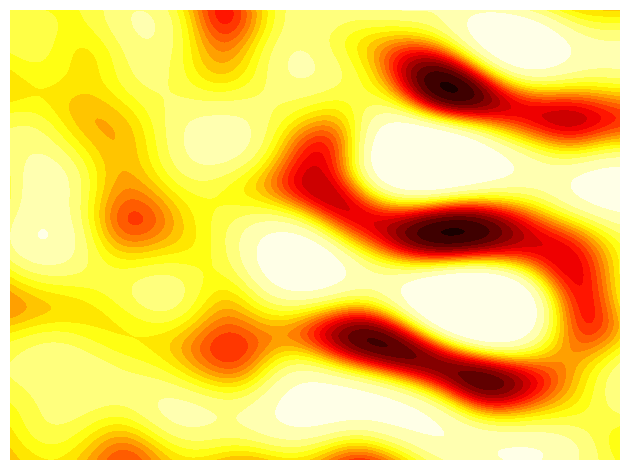

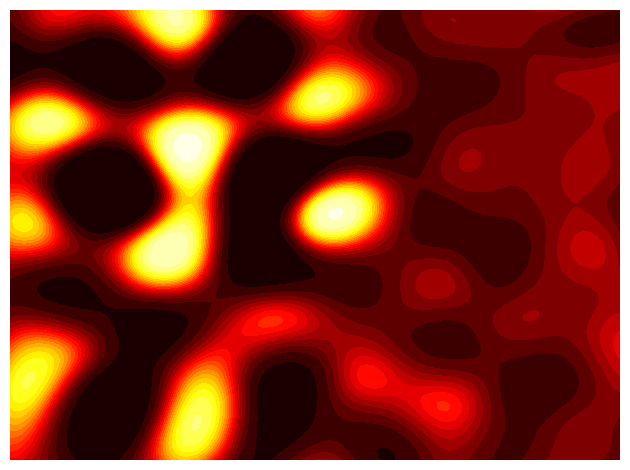

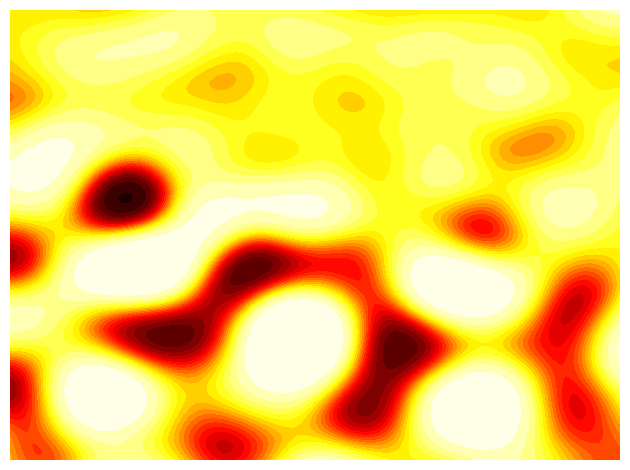

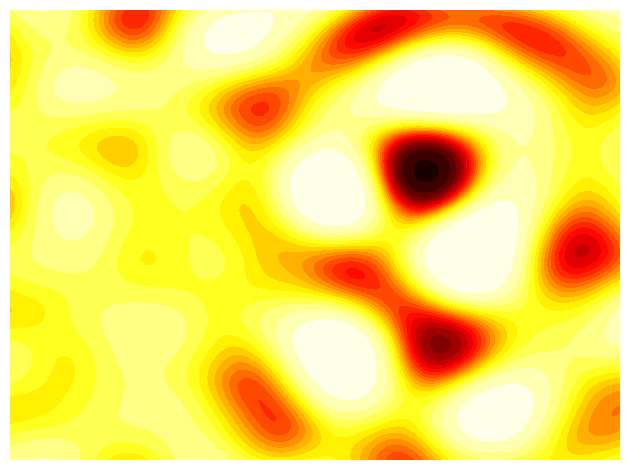

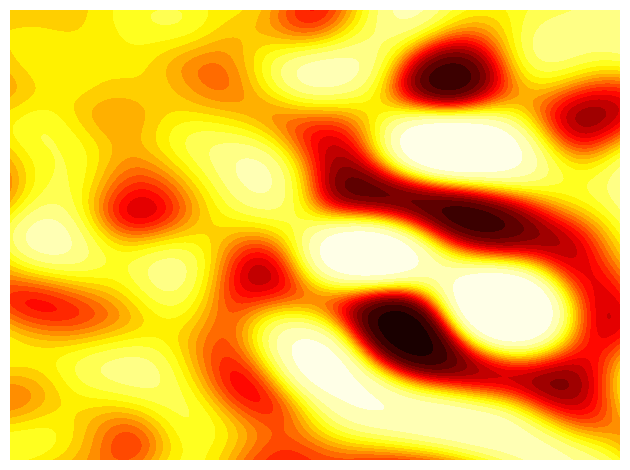

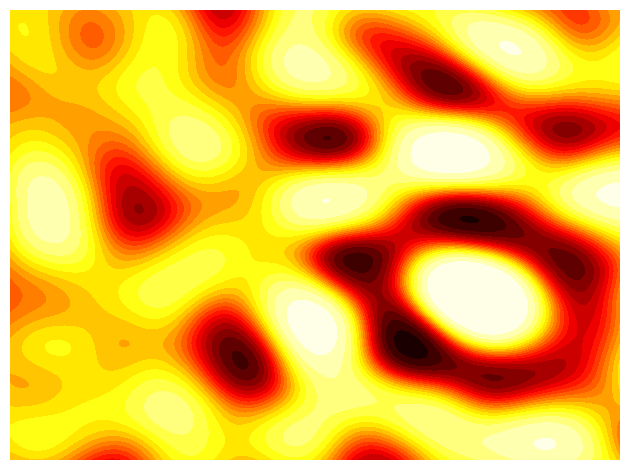

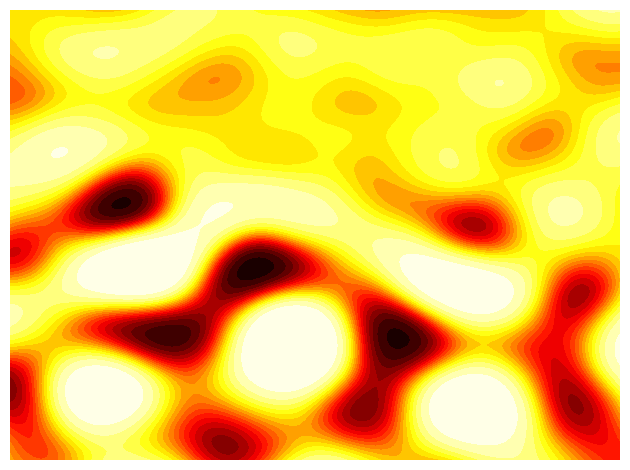

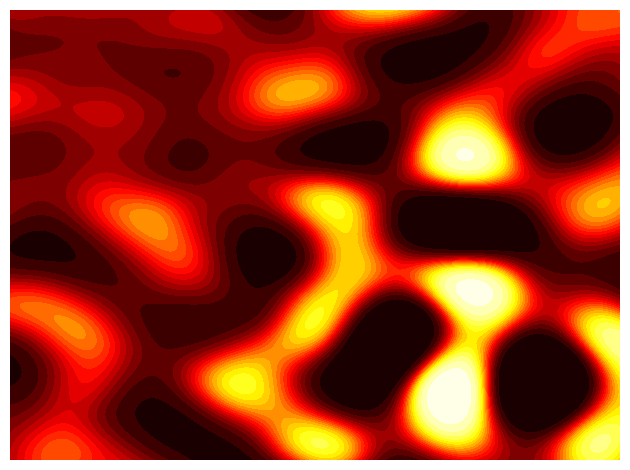

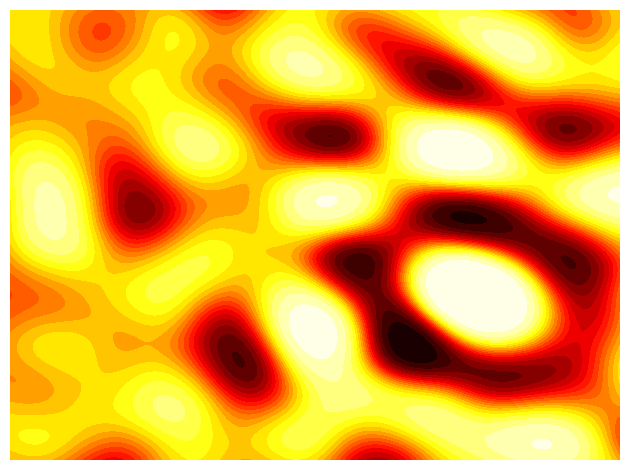

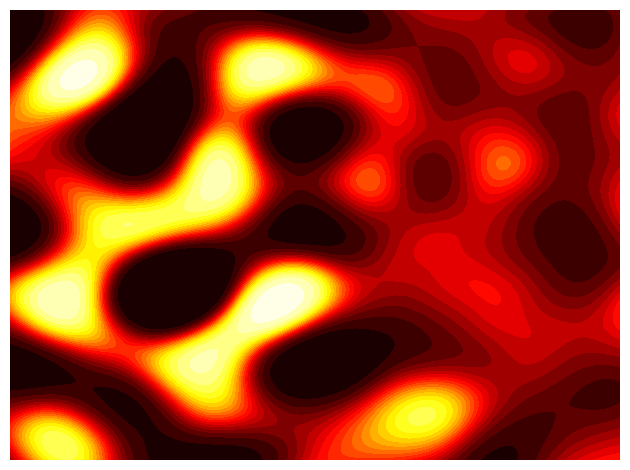

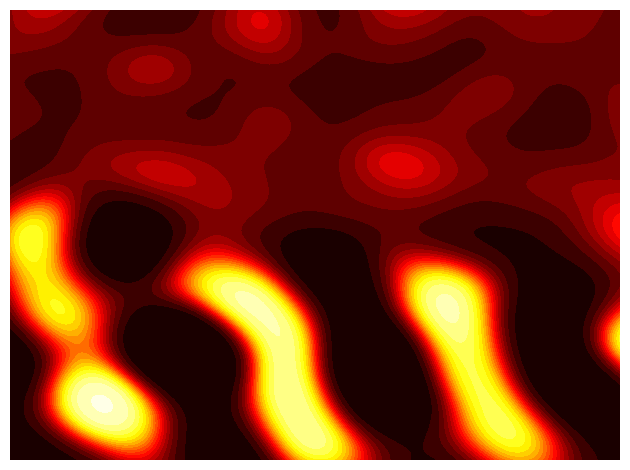

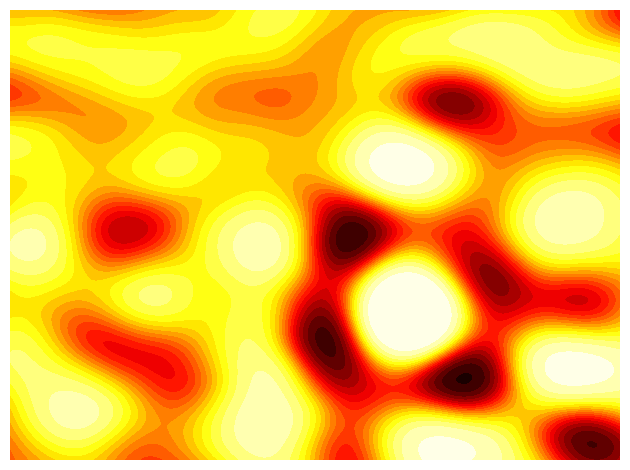

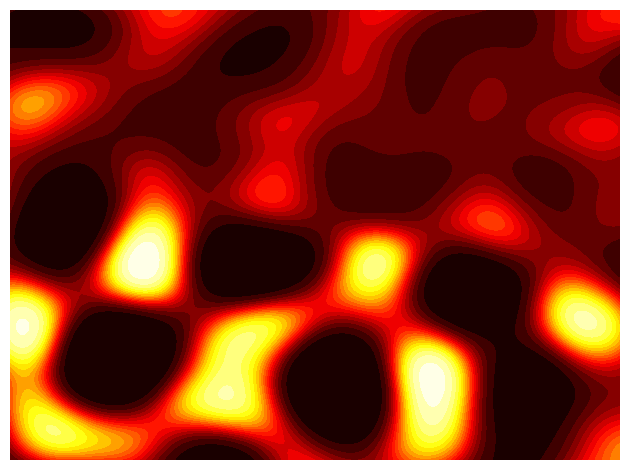

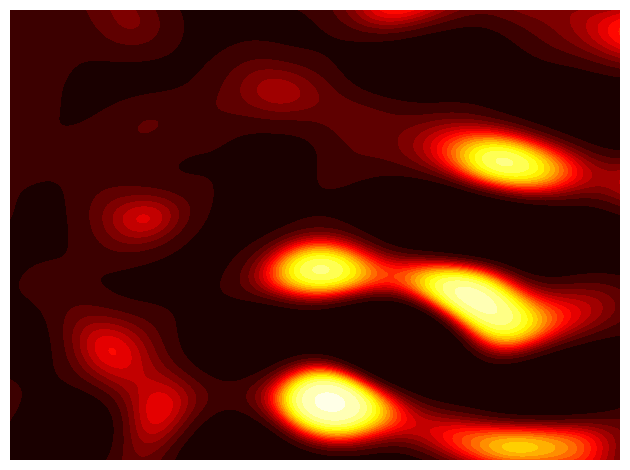

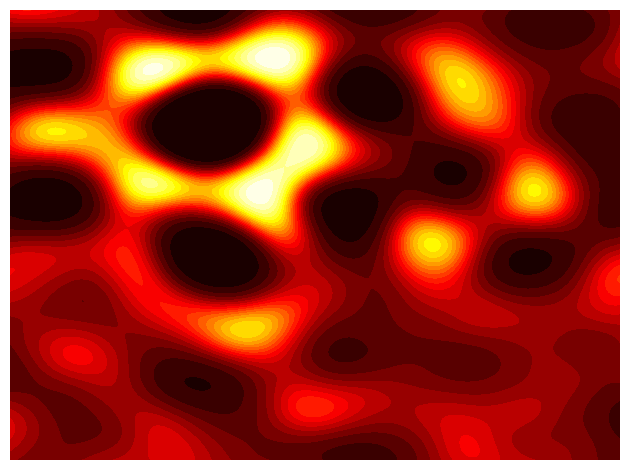

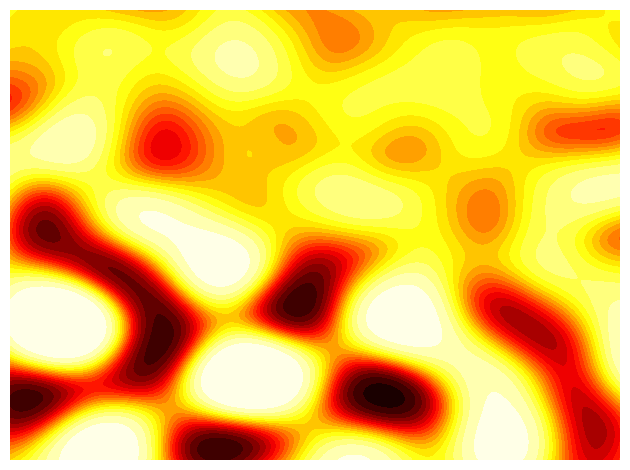

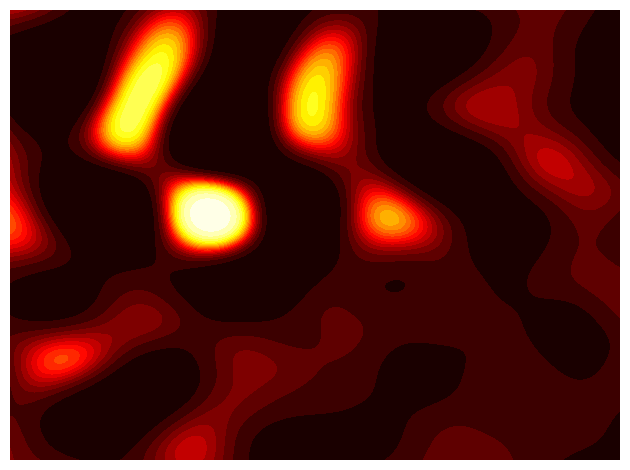

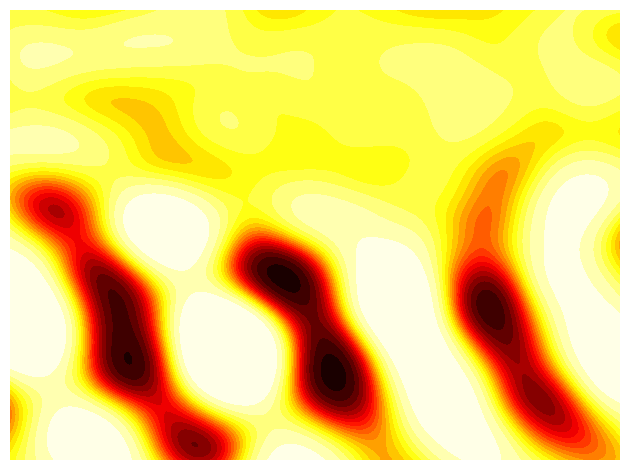

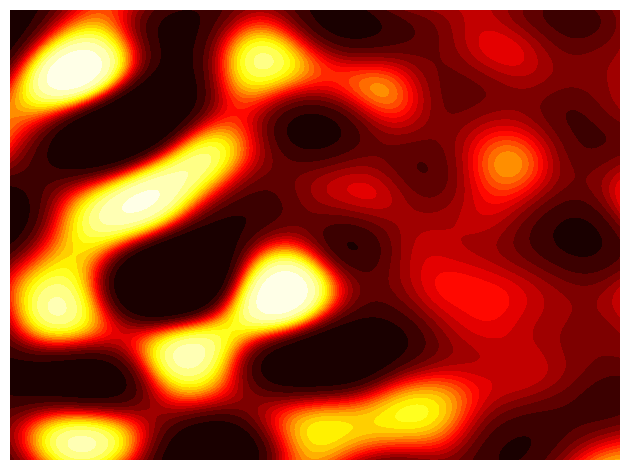

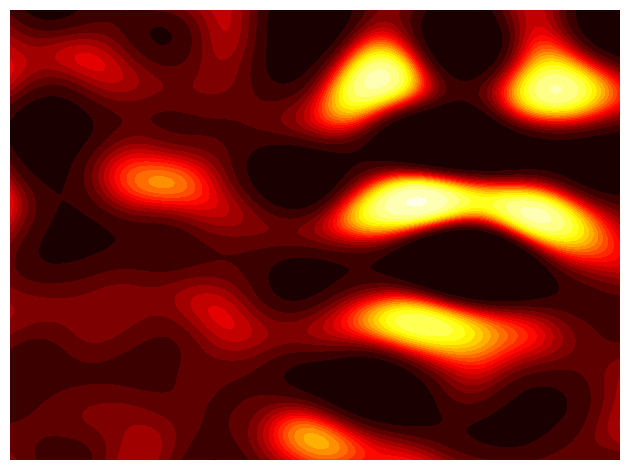

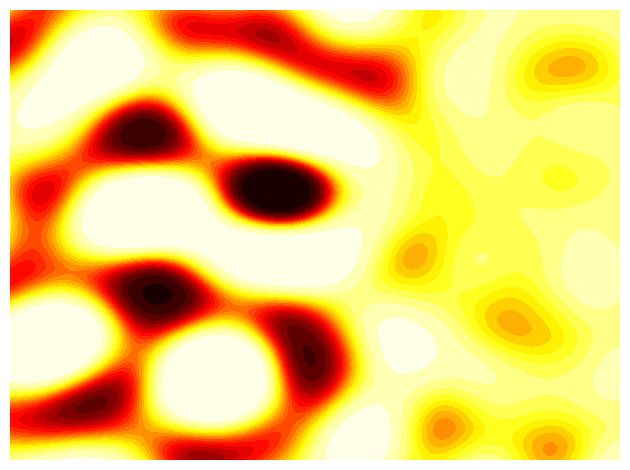

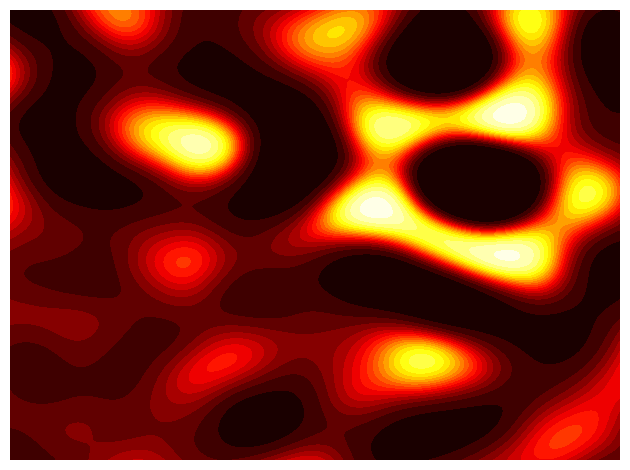

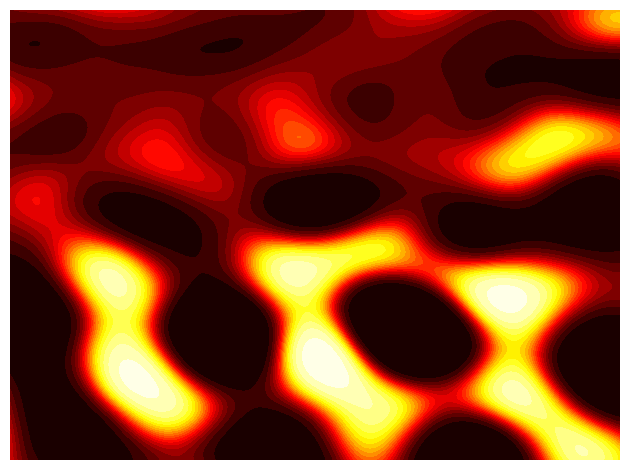

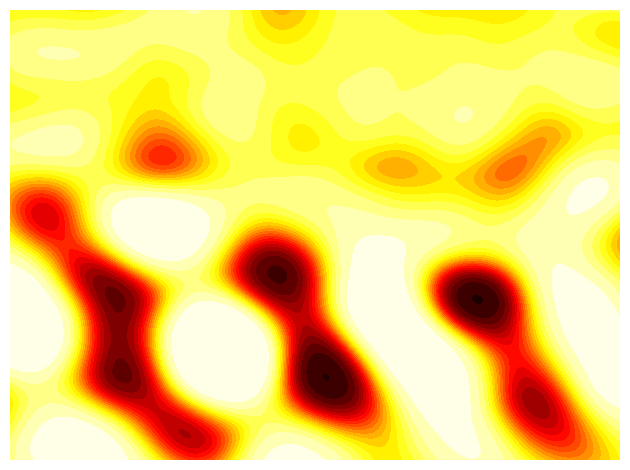

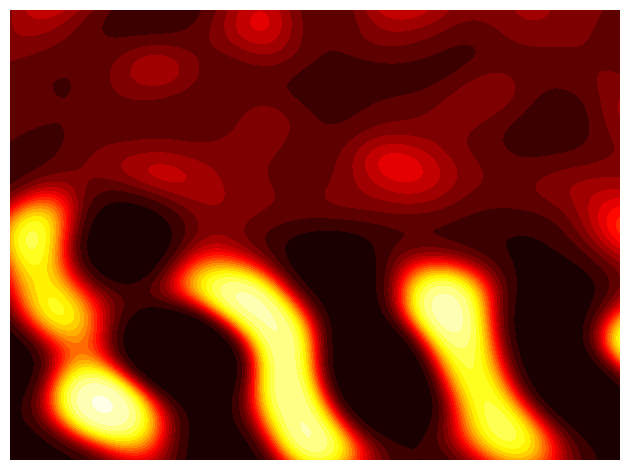

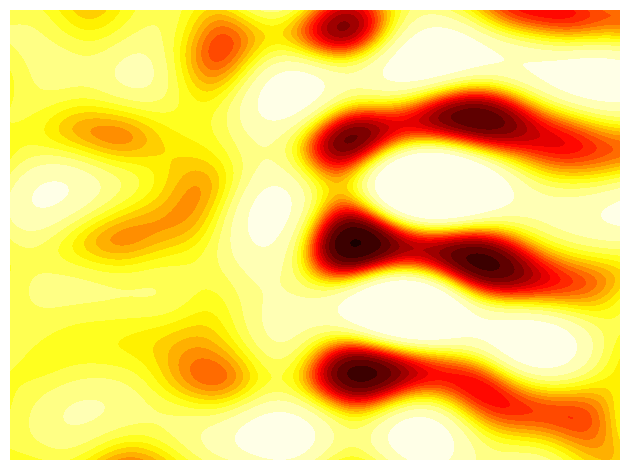

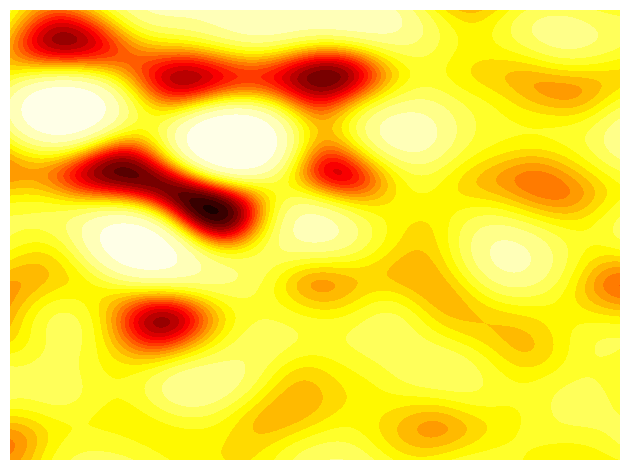

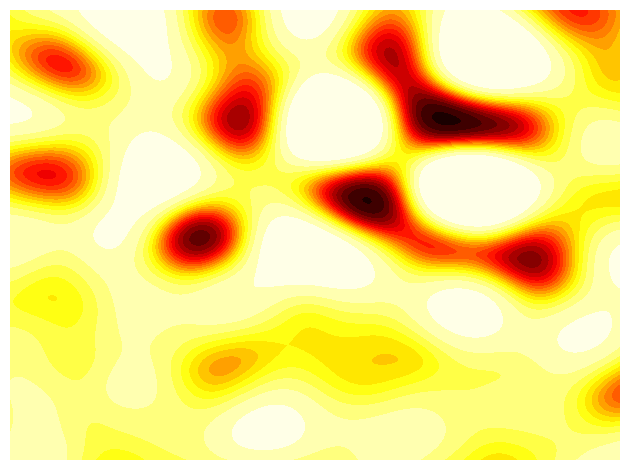

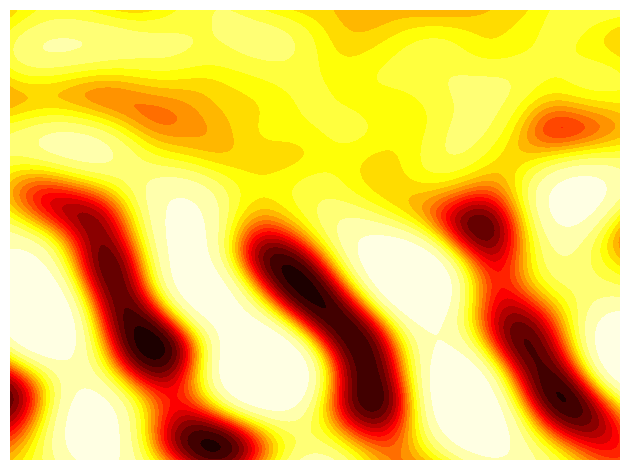

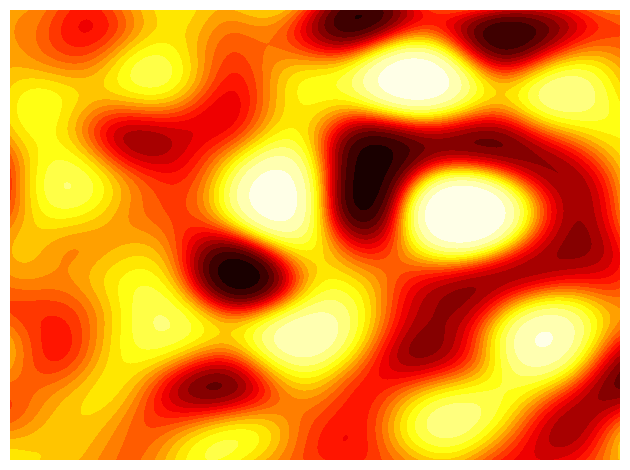

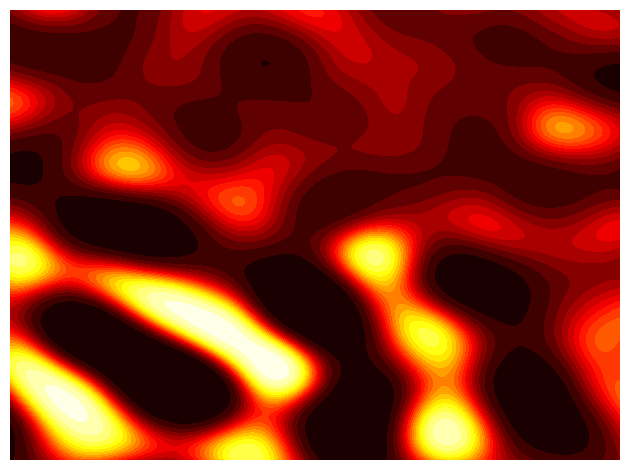

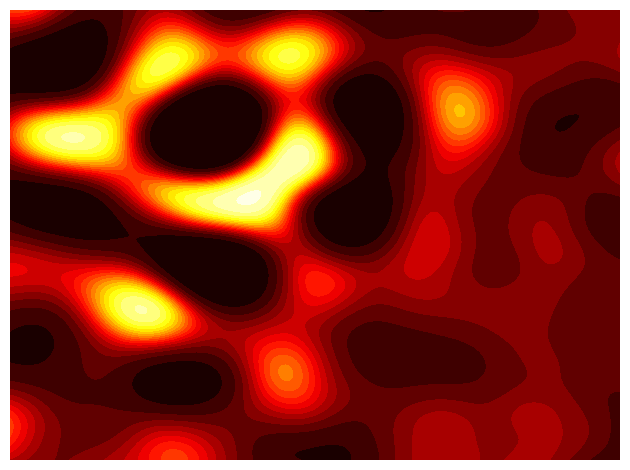

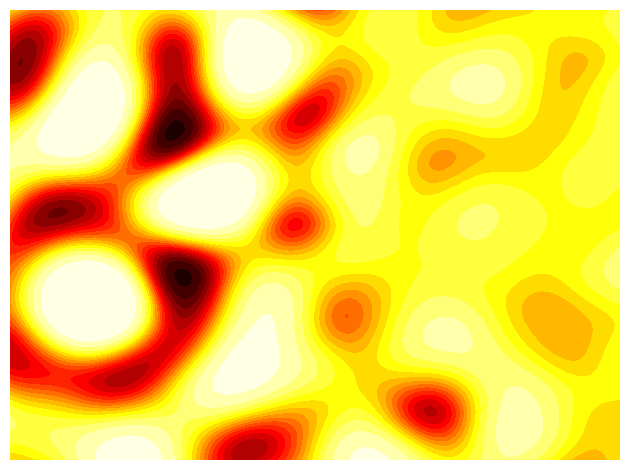

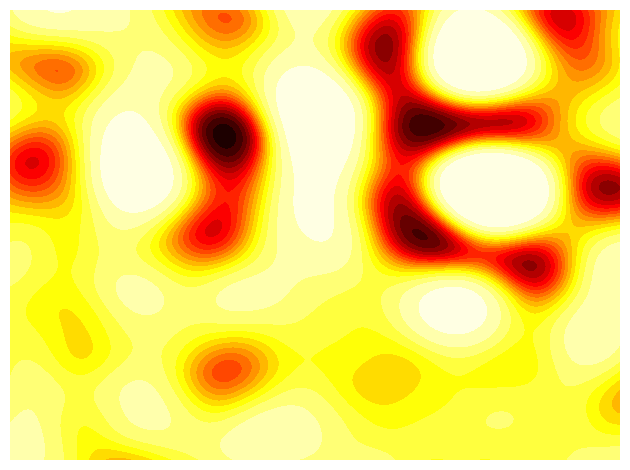

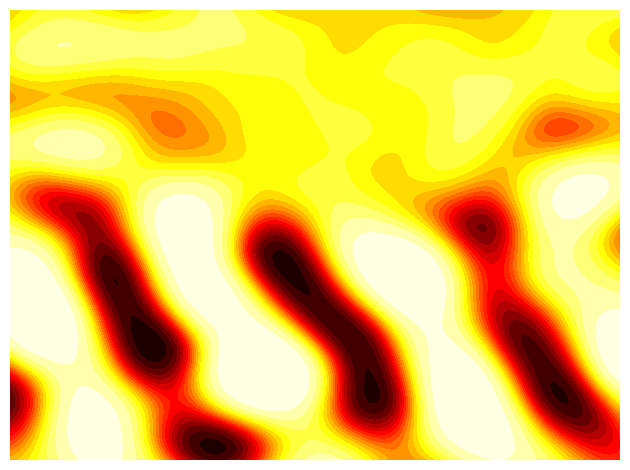

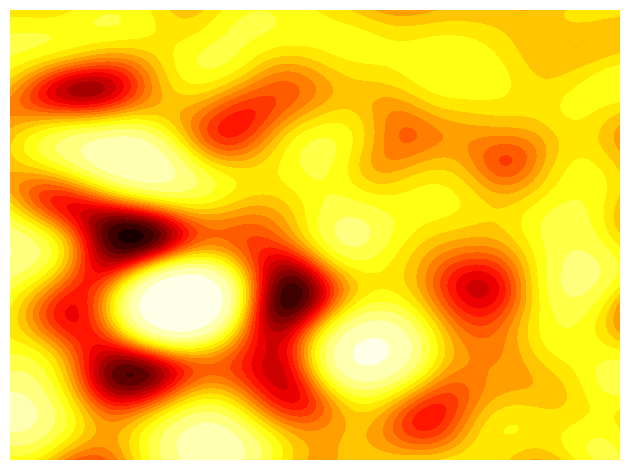

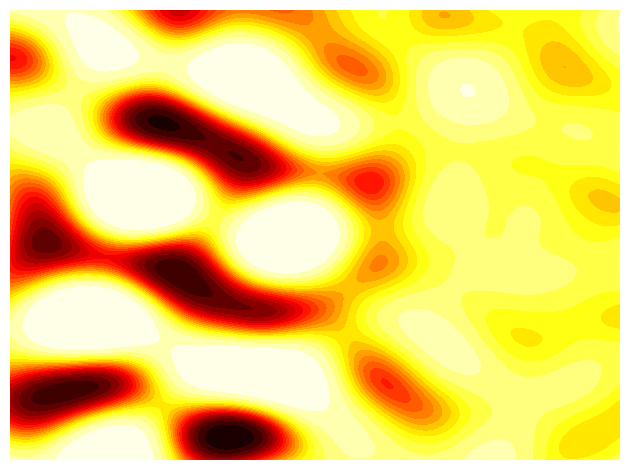

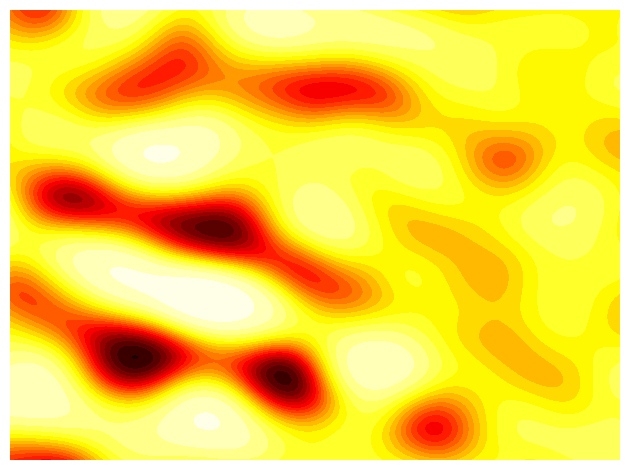

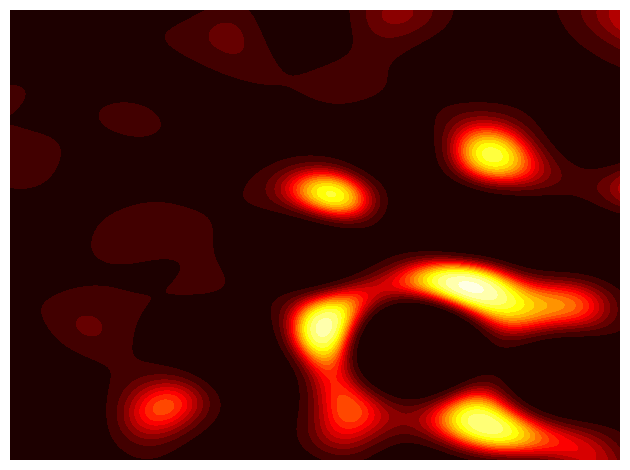

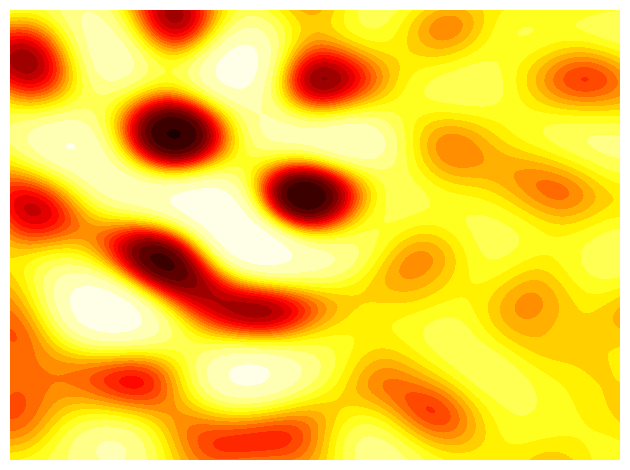

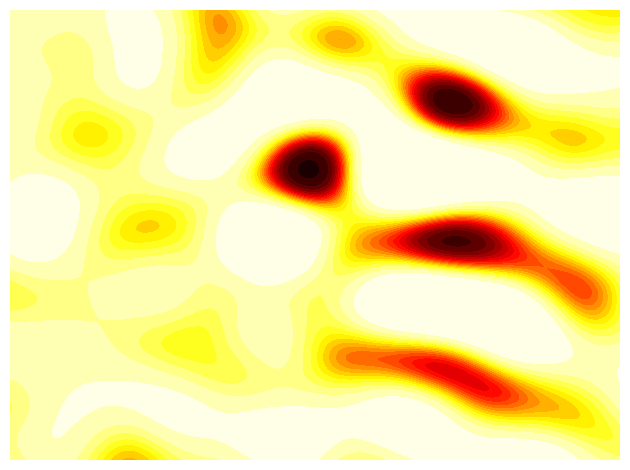

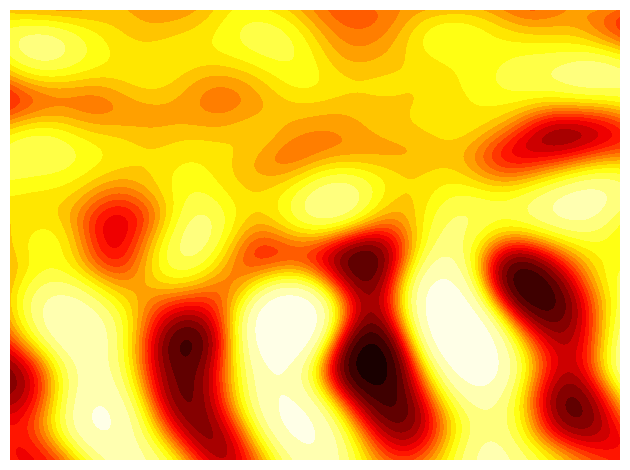

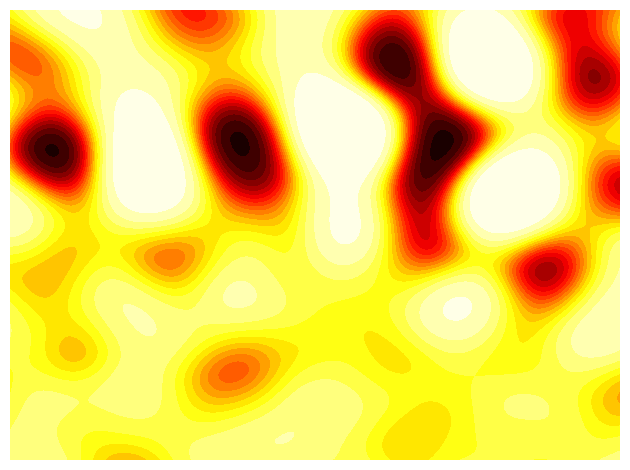

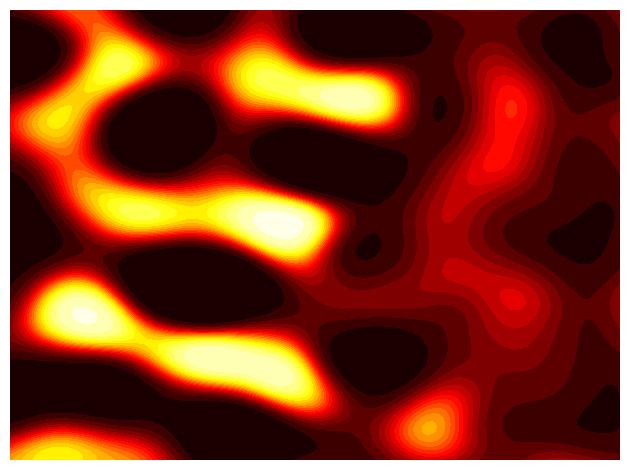

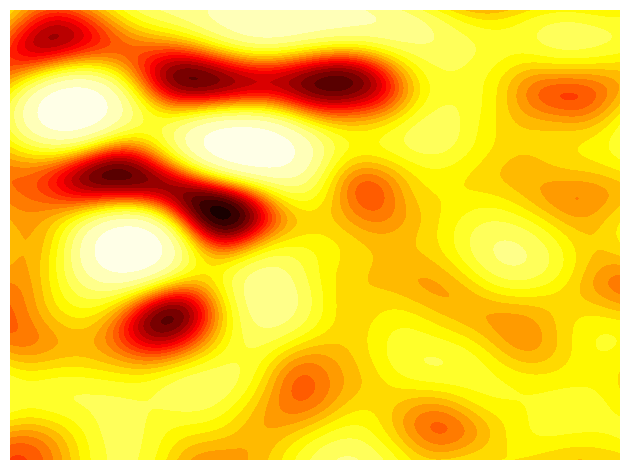

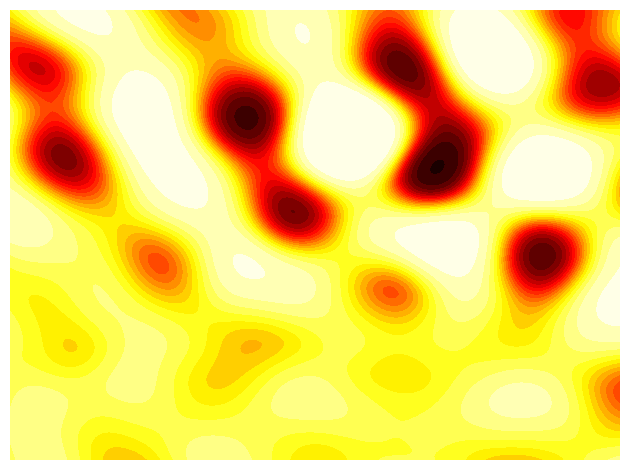

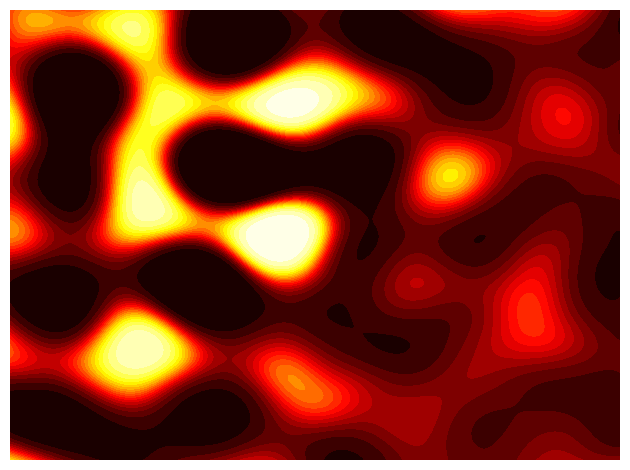

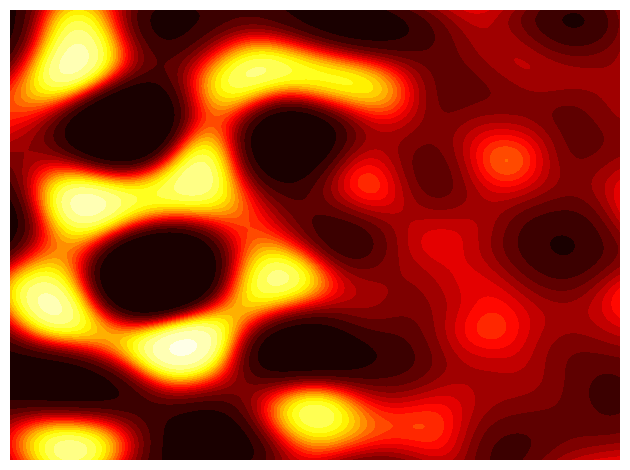

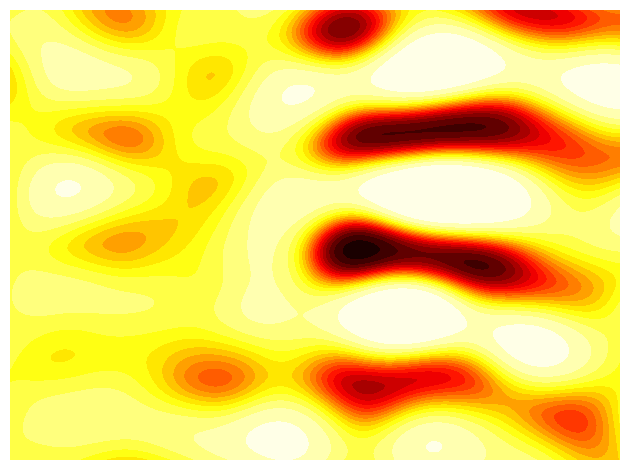

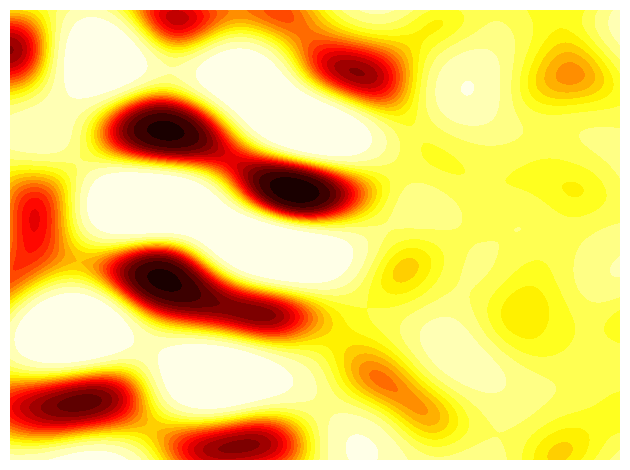

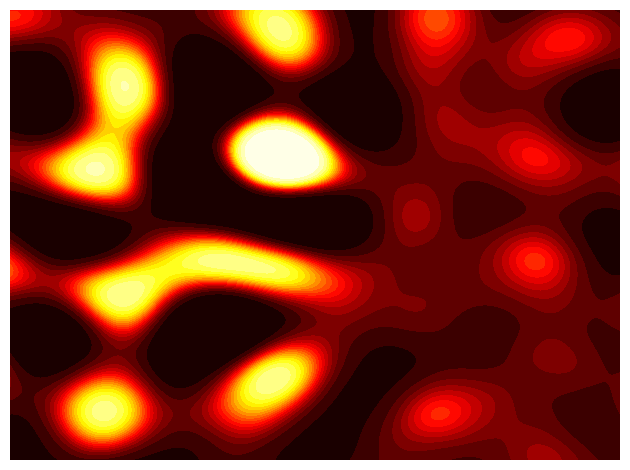

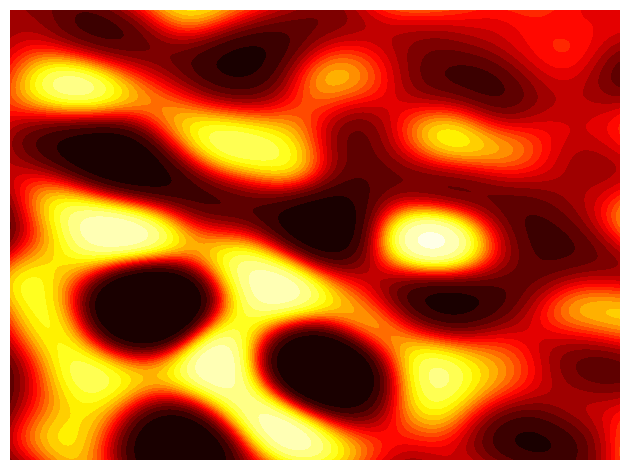

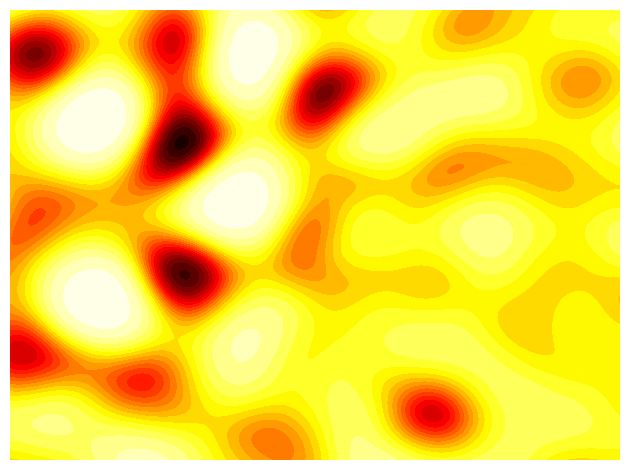

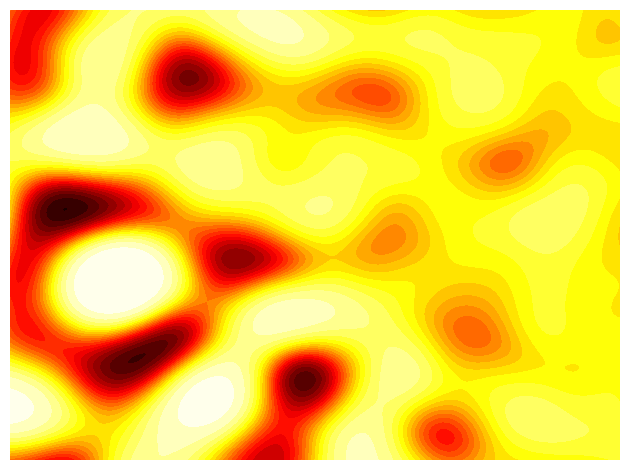

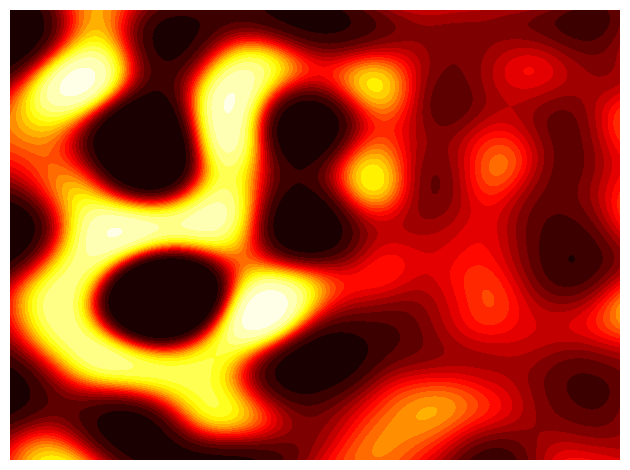

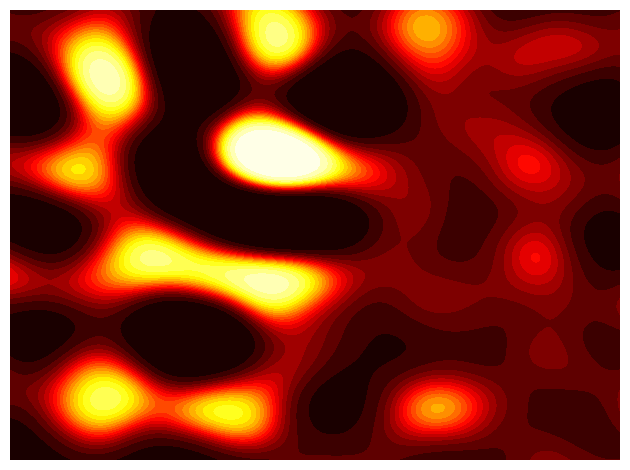

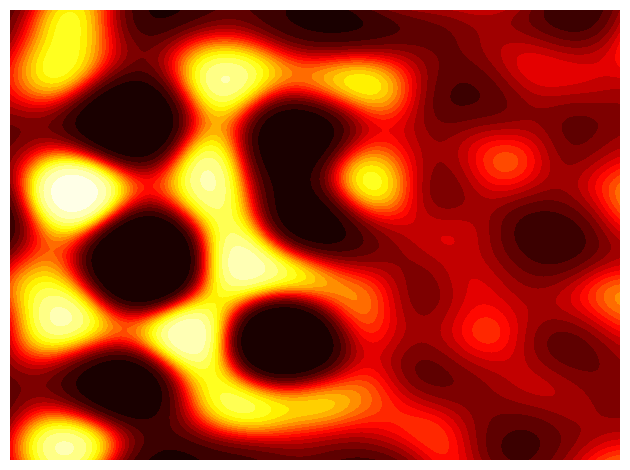

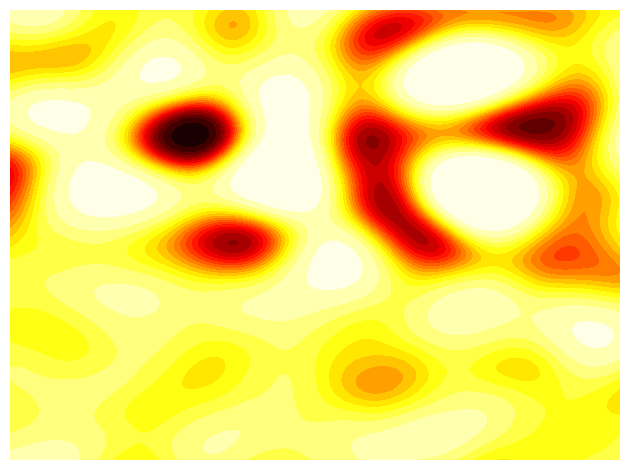

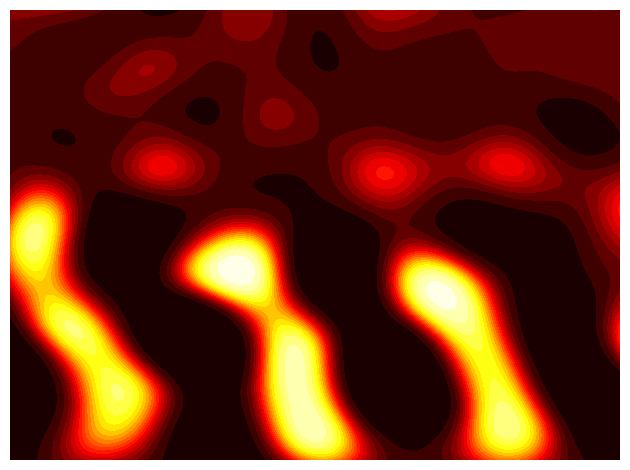

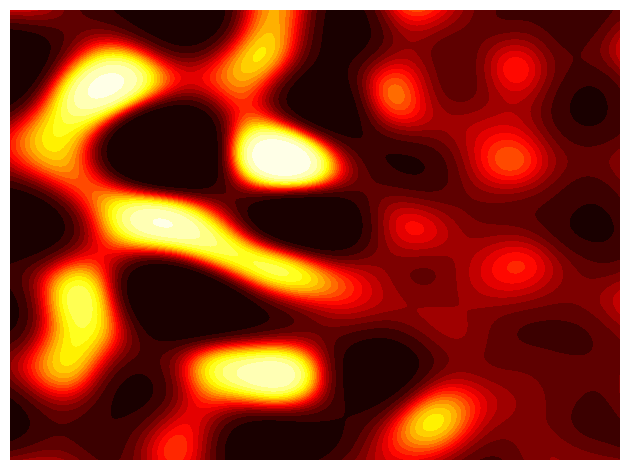

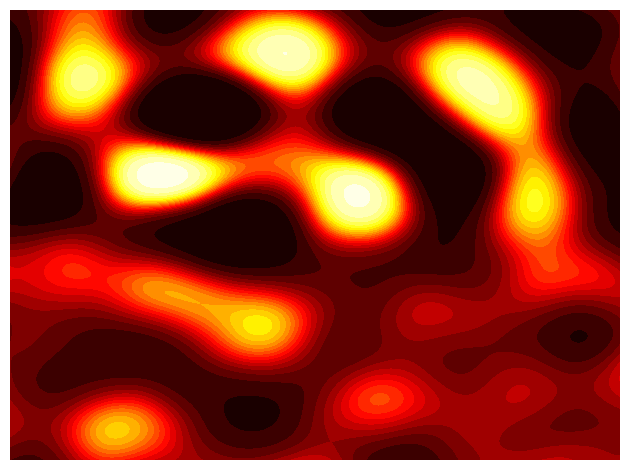

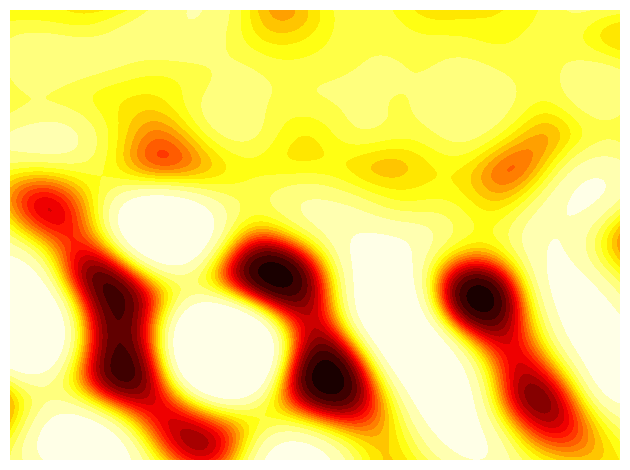

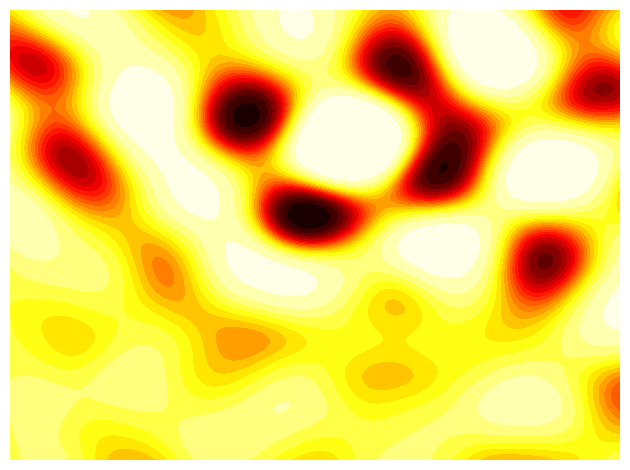

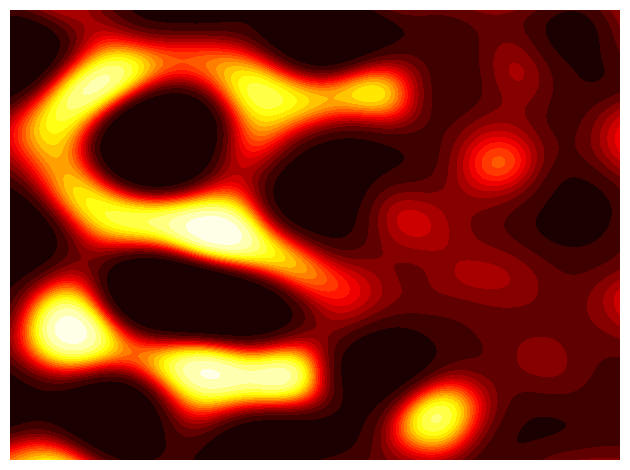

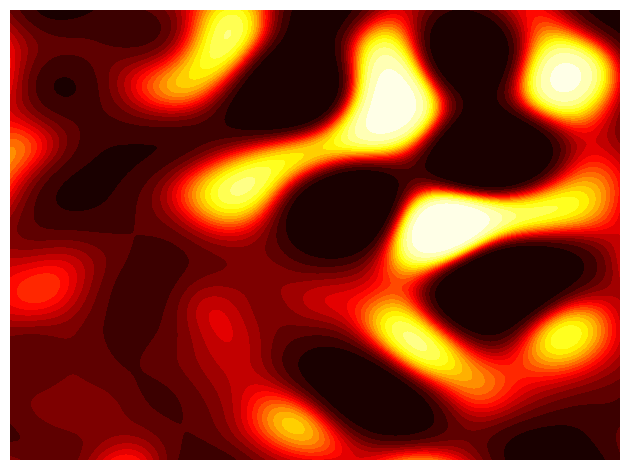

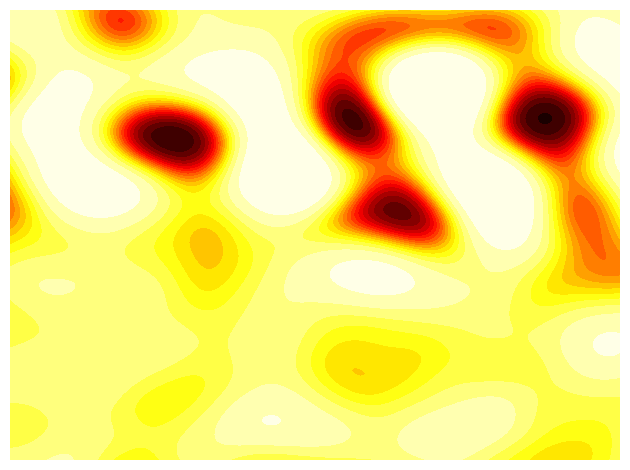

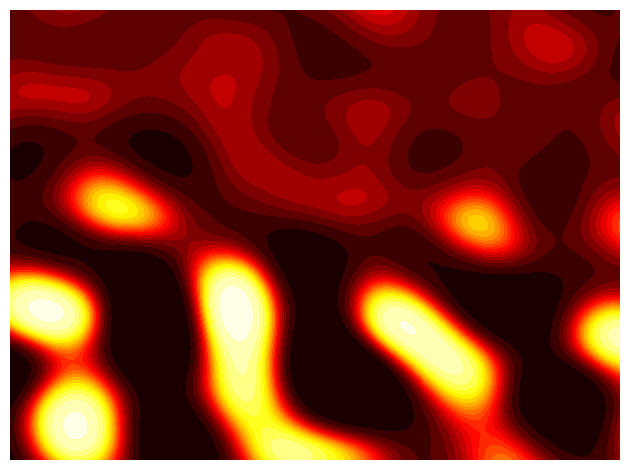

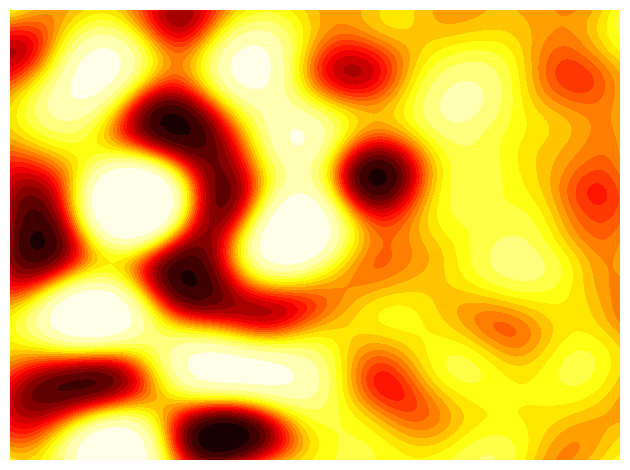

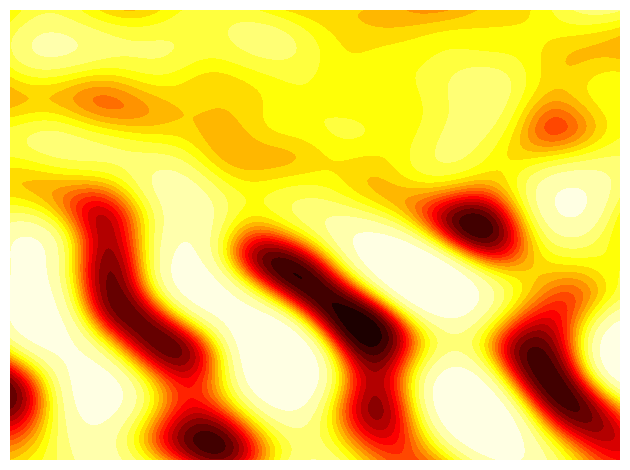

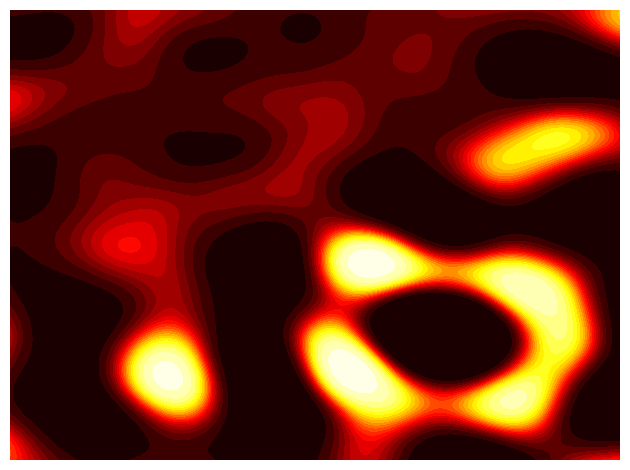

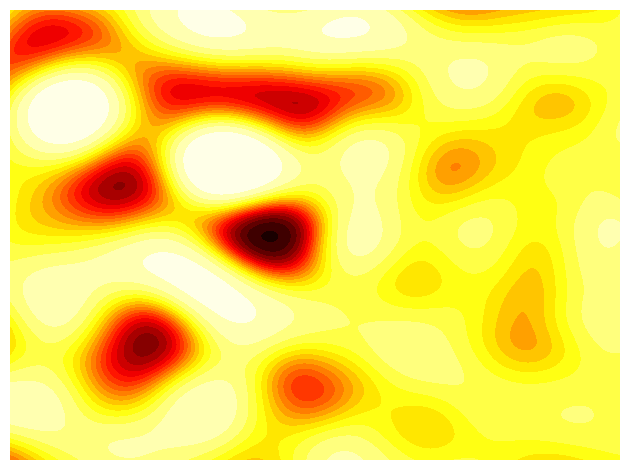

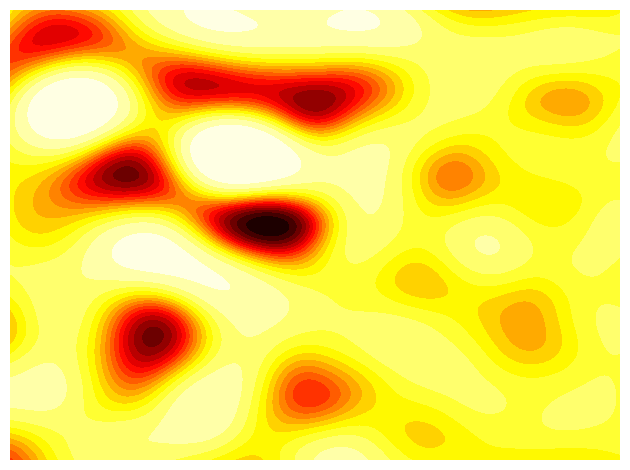

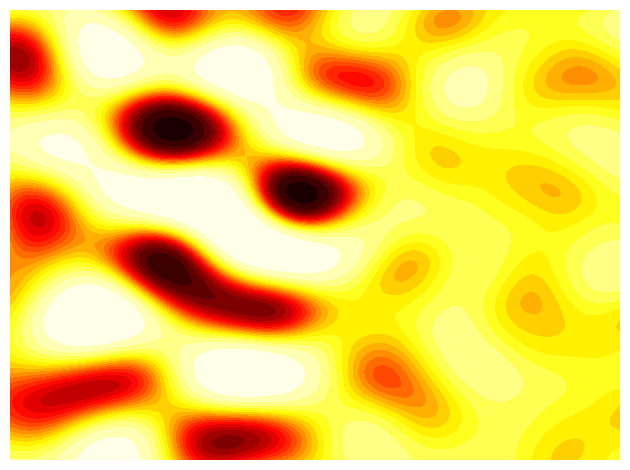

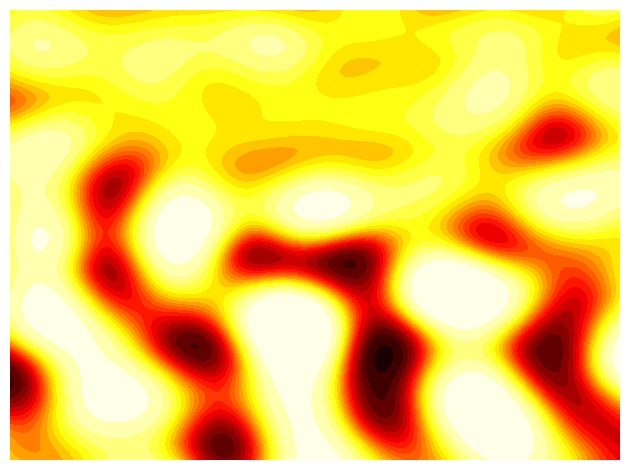

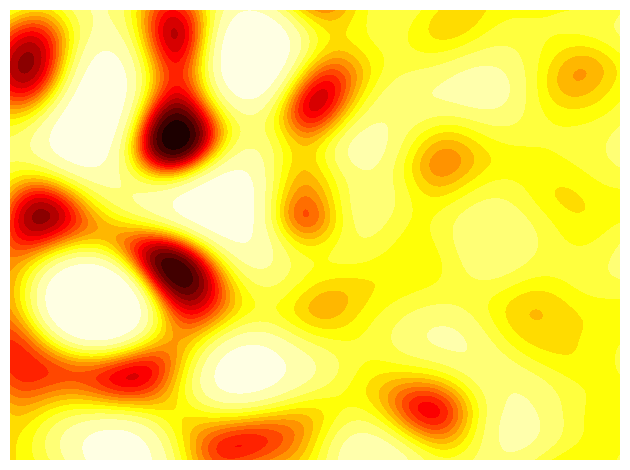

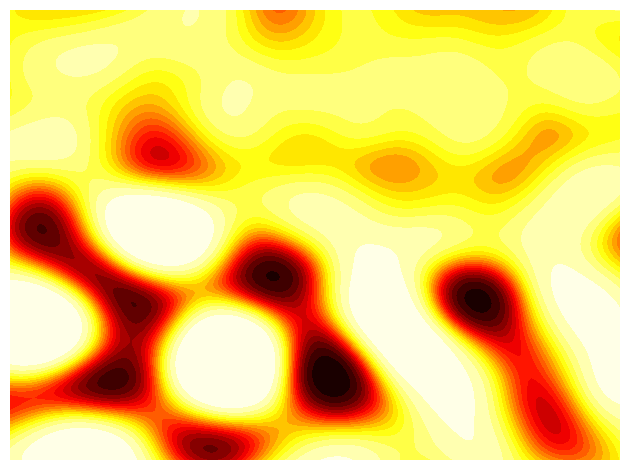

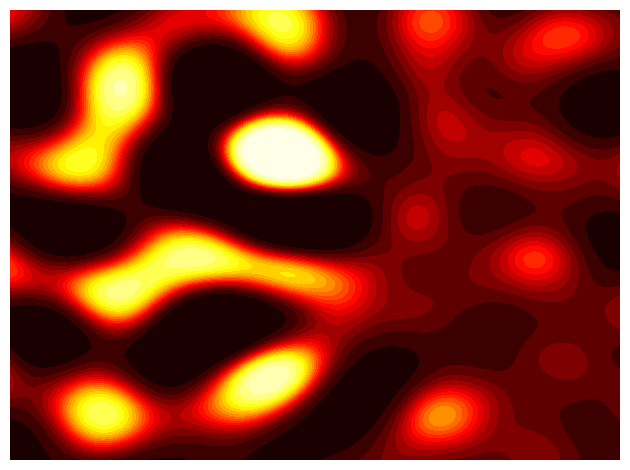

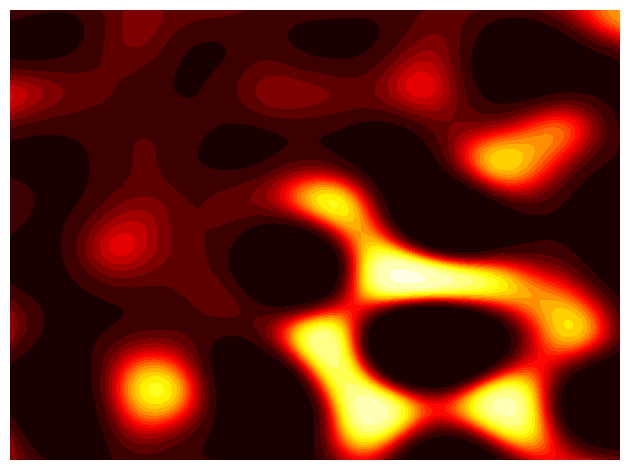

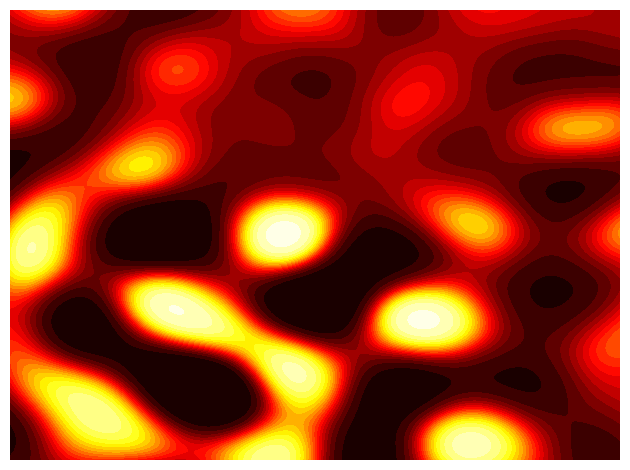

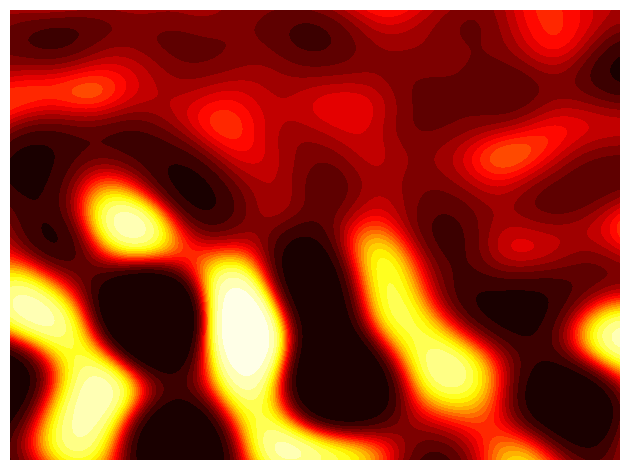

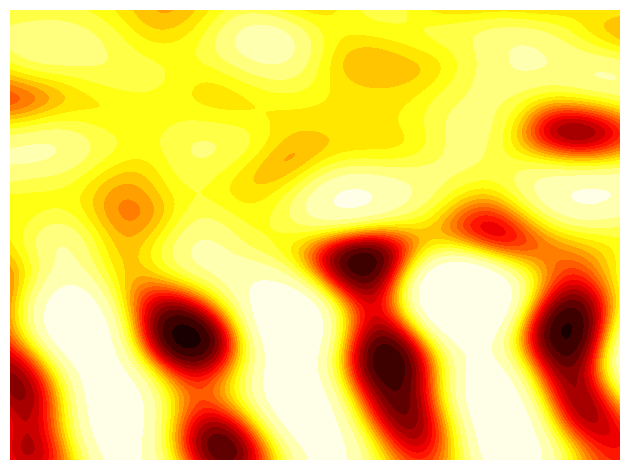

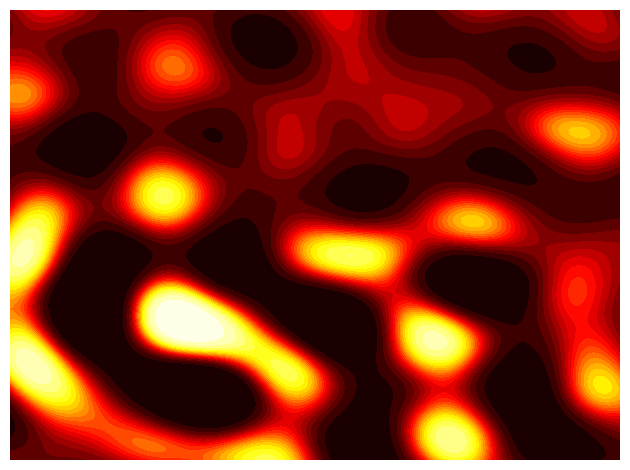

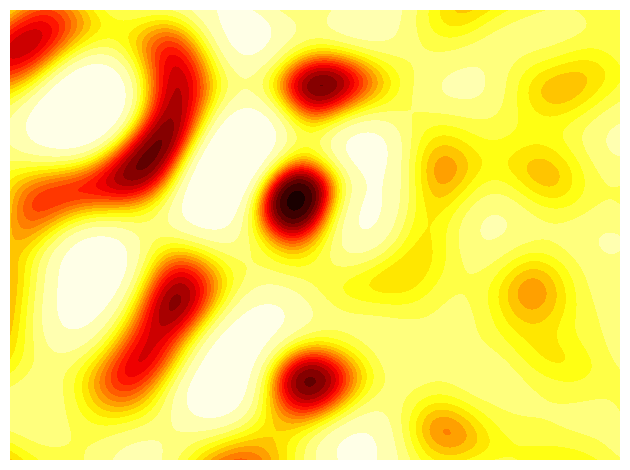

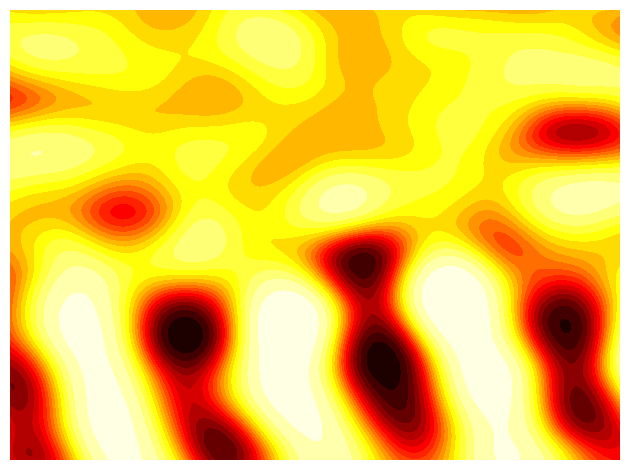

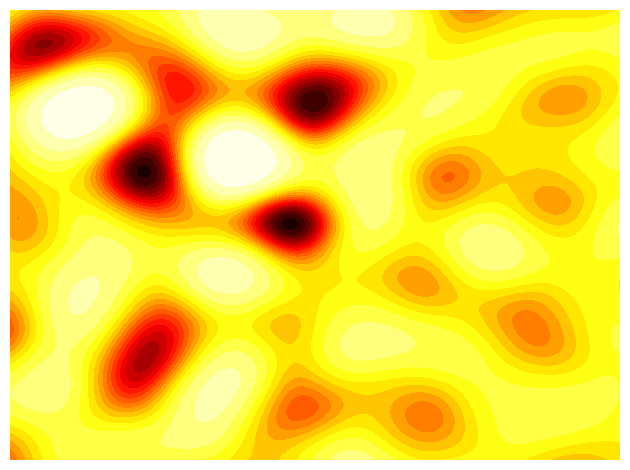

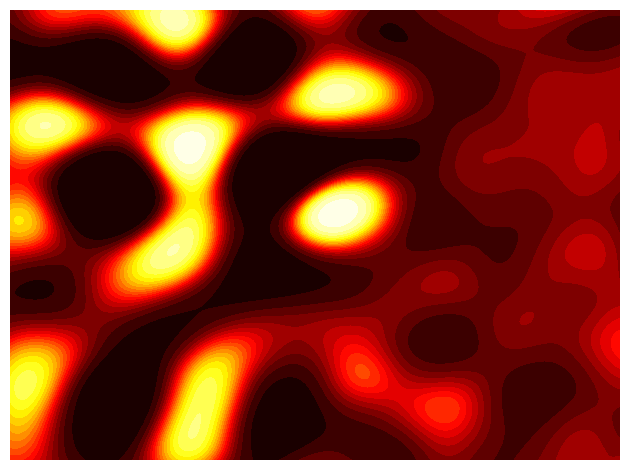

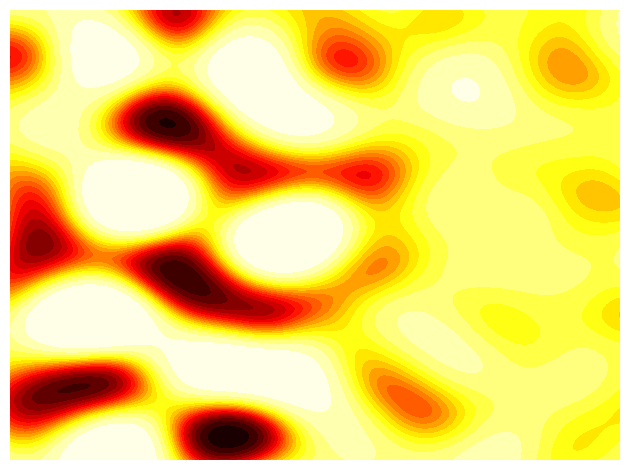

In [61]:
for img in hidden:
    plt.contourf(img, levels=20, cmap='hot')
    plt.axis('off')
    plt.tight_layout()
    plt.show()